In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
import lightgbm as lgb
import torch
import torch.nn as nn
from helper_functions_preprocessing import PreProcessor

##Pytorch Stuff:
import torch.nn.functional as F

# Sklearn Stuff
import sklearn

# Plot stuff:
import seaborn as sns
import matplotlib.pyplot as plt

import itertools

import wandb


# DEL Mini-Challenge 1
Es sollen Immobillienobjekte klassifiziert werden. Von der FHNW haben wir einen Datensatz erhalten (Siehe beiliegendes EDA-Notebook), in denen wir vorraussagen sollen, um was für ein Wohnobjekt es sich handelt; Ist es ein Zimmer? Wohnung? Haus? Diese Challenge hatten wir gelöst, aber ohne Deep Learning. Im beiliegenden EDA-Notebook wurden die Daten sehr genau erforscht.
## Einführung
### Lösung der Mini-Challenge 1 für DEL
Wir benutzen ein Neutal-Network. Zur Erstellung wir das Deep-Learning Framework Pytorch benutzt.
### Ground Truth
Als Ground Truth bentzen wir das Modell, welches wir in der Challenge Immobillienrehcner benutzt haben. Mit diesem haben wir die Macro-F1 Score maximiert, da wir sowohl die Precision, als auch den Recall hoch haben möchten. Ebenfalls haben wir die "Macro" F1 Score optimiert, da wir eine starke Class-Imbalance haben.
### Grobübersicht Inhalt Datensatz
Es gab keine klare Beschreibung, wie gewisse Features (z.B. densities oder gde) zustande gekommen sind. Gde bezieht sich aber auf Gemeinden, in denen das Wohnobjekt liegt. Densities S bis L steht einfach für die Inensitäts des z.B. Waldes. Ist ein grosser Wald, welcher sehr dicht ist? -> ForestDensityL ist hoch. Dies wurde aber nicht zu 100% vom Challengeherausgeber bestätigt.


## Erstellung Modell Ground Truth

In [2]:
#read in data
csv_data = pd.read_csv('immo_dev_data.csv')
csv_data.head()

,Id,AreaLiving,AreaProperty,BuiltYear,FloorNumber,ForestDensityL,ForestDensityM,ForestDensityS,GroupNameDe,HouseObject,...,gde_private_apartments,gde_social_help_quota,gde_tax,gde_workers_sector1,gde_workers_sector2,gde_workers_sector3,gde_workers_total,location_has_street,location_is_complete,PurchasePrice
0,7135329,140.0,501.0,2016,NaN,0.418964,0.555985,0.730714,Haus,True,...,1358.0,3.660512,8.73,17.0,162.0,358.0,537.0,0,0,745000.0
1,7170979,143.0,277.0,2004,NaN,0.033259,0.074061,0.076468,Haus,True,...,3476.0,3.634717,6.13,0.0,2250.0,2787.0,5041.0,1,1,780000.0
2,7172246,160.0,712.0,1945,NaN,0.000000,0.000000,0.000000,Haus,True,...,2806.0,2.512344,9.79,167.0,1694.0,1138.0,2999.0,0,0,570000.0
3,7172252,351.0,496.0,2016,NaN,0.037575,0.000000,0.000000,Haus,True,...,131.0,1.734104,9.15,12.0,10.0,17.0,39.0,0,0,920000.0
4,7172733,400.0,1800.0,1975,NaN,0.095162,0.097193,0.153314,Haus,True,...,1181.0,1.056052,2.97,0.0,27.0,701.0,732.0,0,0,3950000.0


In [3]:
csv_data.columns

Index(['Id', 'AreaLiving', 'AreaProperty', 'BuiltYear', 'FloorNumber',
       'ForestDensityL', 'ForestDensityM', 'ForestDensityS', 'GroupNameDe',
       'HouseObject', 'LastUpdate', 'Latitude', 'Locality', 'Longitude',
       'Name', 'NoisePollutionRailwayL', 'NoisePollutionRailwayM',
       'NoisePollutionRailwayS', 'NoisePollutionRoadL', 'NoisePollutionRoadM',
       'NoisePollutionRoadS', 'PopulationDensityL', 'PopulationDensityM',
       'PopulationDensityS', 'RealEstateTypeId', 'Renovationyear',
       'RiversAndLakesL', 'RiversAndLakesM', 'RiversAndLakesS', 'Rooms',
       'SourceId', 'StateShort', 'StreetAndNr', 'TravelTimeMiv',
       'WorkplaceDensityL', 'WorkplaceDensityM', 'WorkplaceDensityS', 'Zip',
       'distanceToTrainStation', 'gde_area_agriculture_percentage',
       'gde_area_forest_percentage', 'gde_area_nonproductive_percentage',
       'gde_area_settlement_percentage', 'gde_average_house_hold',
       'gde_empty_apartments', 'gde_foreigners_percentage',
       'g

### Daten vorbereiten mit der Klasse PreProcessor
PreProcessor ist eine Klasse, welche ich geschrieben habe um Daten nach Standardverfahren zu preprozessieren.
Die Daten wurden folgendermassen preprozessiert:
- Onehot-Encoden: Kategorische Daten oder Strings werden Onehot-encoded. Dies bedeutet, dass ein Attribut in mehrere Attribute binär aufgeteilt wird und diese neuen Attribute sagen, ob dieser Eintrag ein String oder Kategorie enthält.
- Standardisieren auf die Z-Score: z=(x−μ)/σ​. (σ ist entweder die Standardabweichung oder das 75% Quantil subtrahiert vom 25% Quantil, falls der Robust-Scaler verwendet wird.)
- NANs auffüllen (entweder mit Mean oder Median oder mit einem bestimmten String).
- auf allen geskewten Werten eine Boxcox-Transformation durchführen, wobei dies bei unseren Test das Ergebniss nicht verbessert hat.
- 'StreetAndNr', 'LastUpdate', 'Locality', 'Id' werden gedropped; 'StreetAndNr' und 'LastUpdate' haben zuviele, einzigartige Werte und 'Locality' ist bereits im Zipcode vorhanden.
- Falls ein Attribut nur Werte zwischen 0 und 1 hat, wird ein neues Attribut kreiert, welches besagt, dass dieses Attribut 0 ist.
- Falls ein Attribut NANs hatte, wird ein neues Attribut erstellt, welches zeigt, wo ein Attribut NANs hatte.
- Wie in EDA gesehen, reicht es, wenn wir nur die ersten zwei Ziffern von der Zip benutzen. 
- Wir haben einen balancierten Train/Test-Split (alle Klassen kommen im Train/Test prozentual gleichoft vor) erzeugt.

Ebenfalls hat es 3 Reihen, welche alles NA sind. Diese kamen auch nicht im Kaggle-Datensatz vor, welches man hochladen konnte (teil der Challenge). Diese werden am Anfang also entfernt. 


In [4]:
csv_data_fe = csv_data.copy()
## Drop der Reihen mit nur NAs:
csv_data_fe = csv_data_fe[csv_data_fe['TravelTimeMiv'].notna()].copy()
csv_data_fe = csv_data_fe[csv_data_fe['StateShort'].notna()].copy()
csv_data_fe = csv_data_fe[csv_data_fe['gde_area_settlement_percentage'].notna()].copy()

## Drop der Säulen, welche höchstwahrscheinlich

# Zip vereinfachen:
csv_data_fe['Zip'] = (csv_data_fe['Zip']/1000).astype('int8')
prepro = PreProcessor(csv_data_fe, y_var='GroupNameDe', method_to_encode='onehot_encode', cols_to_drop=['Id', 'LastUpdate', 'Locality', 'StreetAndNr', 'Longitude', 'Latitude', 'HouseObject','RealEstateTypeId'], numbers_to_encode=['Zip'], test_frac=0.2, remove_skew_by_boxcox = True)
prepro.preprocess()

### Metriken
Wir beginnen mit 2., den Metriken. Hierfür müssen wir uns als erstes einen Überblick über unsere Zielvariable verschaffen. Schauen wir einmal, wie viele verschiedene Objekttypen es gibt und wie viele Objekte es für jeden Typen gibt.

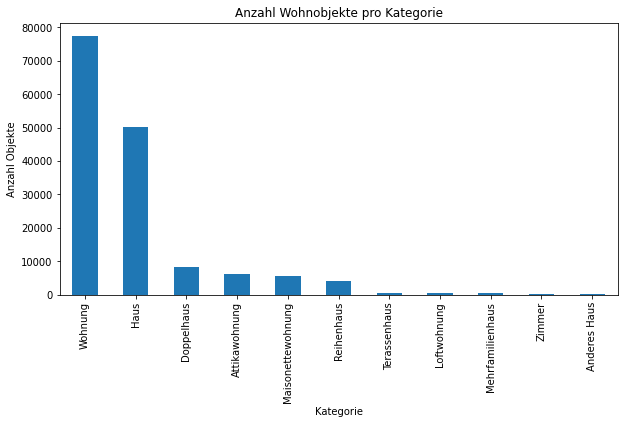

In [5]:
csv_data['GroupNameDe'].value_counts().plot(kind='bar', figsize=(10, 5), rot = 90)
plt.xlabel("Kategorie")
plt.ylabel("Anzahl Objekte")
plt.title("Anzahl Wohnobjekte pro Kategorie")
plt.show()

 Man kann im Plot sehr gut erkennen, dass es sich hier im eine ungleichmäsige Verteilung der Kategorien handelt. Da man einige Kategorien gar nicht erkennen kann, schauen wir noch die Zahlen an:

In [6]:
 csv_data['GroupNameDe'].value_counts()

Wohnung              77499
Haus                 50265
Doppelhaus            8397
Attikawohnung         6215
Maisonettewohnung     5517
Reihenhaus            4168
Terassenhaus           533
Loftwohnung            474
Mehrfamilienhaus       444
Zimmer                  89
Anderes Haus            26
Name: GroupNameDe, dtype: int64

Wir sehen also klar, dass die Daten extrem unbalanced sind. Dazu gibt es verschiedene Techniken. In der Challenge haben wir Oversampling benutzt.

### Oversampling
Oversampling bedeutet, dem Datensatz werden neue Objekte hinzugefügt um eine "Anzahl"-Balance zwischen allen Klassen herzustellen. Hierfür kann man bestehende Objekte zufällig auswählen und mehrmals hinzufügen bzw. kopieren oder komplett neue Objekte – basierend auf den bereits existierenden – erstellen. Dies funktioniert beispielsweise mit der SMOTE Methode. Hiermit werden wir uns auch beschäftigen.

In [7]:
ros = RandomOverSampler(random_state = 69)
X_random_, y_random_ = ros.fit_resample(prepro.X_train, prepro.y_train)
X_random = X_random_.sample(len(prepro.X_train), random_state = 69)
y_random = y_random_.iloc[X_random.index]

### Model trainieren
Wie oben gesagt, wird das NN verglichen mit einem Lightgbm-Mode, welches zu den "Boosted Tree"-Modellen gehört. Die besten Parameter haben wir schon gefunden gehabt mit Hilfe von Bayesian Optimization.

In [8]:
lgbc_best = lgb.LGBMClassifier(
        n_jobs = -1, seed = 42, learning_rate = 0.07517, max_depth = 340, n_estimators = 344,
        num_leaves = 90, reg_alpha = 1.136, reg_lambda = 4.348
)
lgbc_best.fit(X_random, y_random)

LGBMClassifier(learning_rate=0.07517, max_depth=340, n_estimators=344,
               num_leaves=90, reg_alpha=1.136, reg_lambda=4.348, seed=42)

In [9]:
lgbc_y_pred_best = lgbc_best.predict(prepro.X_test)

In [10]:
 print(sklearn.metrics.classification_report(prepro.y_test, lgbc_y_pred_best))

                   precision    recall  f1-score   support

     Anderes Haus       0.00      0.00      0.00         5
    Attikawohnung       0.32      0.67      0.43      1243
       Doppelhaus       0.39      0.58      0.47      1679
             Haus       0.92      0.80      0.86     10053
      Loftwohnung       0.43      0.54      0.48        95
Maisonettewohnung       0.29      0.56      0.38      1103
 Mehrfamilienhaus       0.32      0.55      0.40        89
       Reihenhaus       0.37      0.60      0.46       834
     Terassenhaus       0.49      0.64      0.56       107
          Wohnung       0.95      0.80      0.87     15500
           Zimmer       0.12      0.11      0.12        18

         accuracy                           0.76     30726
        macro avg       0.42      0.53      0.46     30726
     weighted avg       0.84      0.76      0.79     30726



In [11]:
prepro.X_test.shape

(30726, 136)

### Confusion Matrix LightGBM

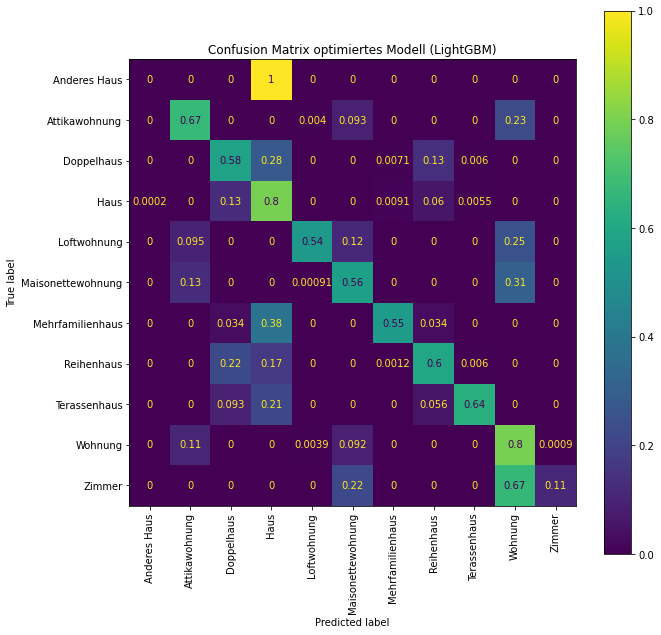

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
sklearn.metrics.plot_confusion_matrix(lgbc_best, prepro.X_test, prepro.y_test, normalize = 'true', xticks_rotation='vertical', ax = ax)
plt.title('Confusion Matrix optimiertes Modell (LightGBM)')
plt.show()

## Wichtigkeit der Features

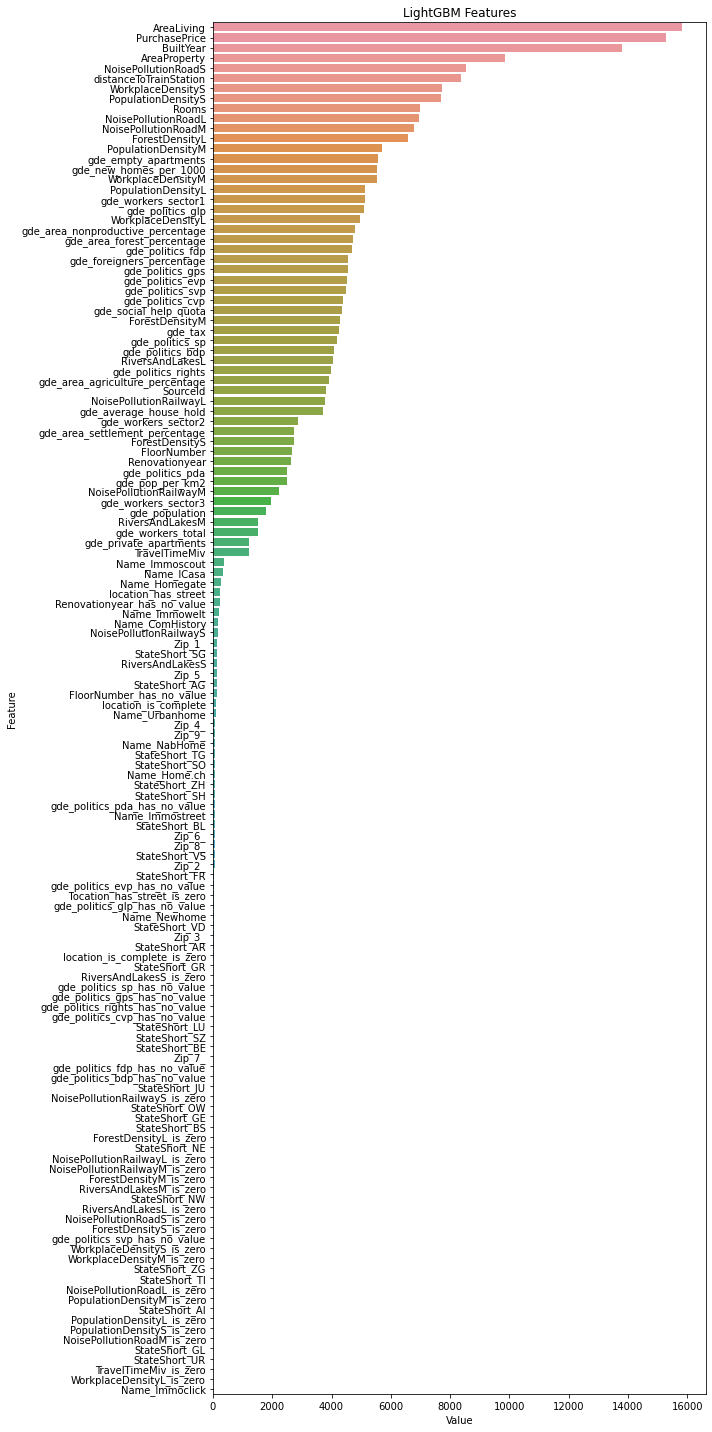

<Figure size 432x288 with 0 Axes>

In [13]:
feature_imp = pd.DataFrame(sorted(zip(lgbc_best.feature_importances_,prepro.X_test.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

Wir sehen also, dass die meisten Features gar keinen Einfluss haben auf die Klassifizierung. Wir stehlen diese Informationen für unser NN um dieses nicht mit Features zu überladen, welche keine Information beinhalten. Für das NN behalten wir also nur diese, welche mehr Einfluss haben als deren Wichtigkeit geteilt durch 2. Damit haben wir noch 53 Features.

In [14]:
features_to_drop = feature_imp[feature_imp.sort_values(by='Value', ascending=False)['Value']<feature_imp.sort_values(by='Value', ascending=False)['Value'].mean()/2]

<ipython-input-14-8b8535232176>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  features_to_drop = feature_imp[feature_imp.sort_values(by='Value', ascending=False)['Value']<feature_imp.sort_values(by='Value', ascending=False)['Value'].mean()/2]


In [15]:
features_to_drop

,Value,Feature
0,0,Name_Immoclick
1,0,NoisePollutionRoadM_is_zero
2,0,PopulationDensityL_is_zero
3,0,PopulationDensityM_is_zero
4,0,PopulationDensityS_is_zero
...,...,...
78,234,Renovationyear_has_no_value
79,236,location_has_street
80,286,Name_Homegate
81,338,Name_ICasa


In [16]:
# Save Features to drop:
features_to_drop.to_csv('features_to_drop.csv', index=False)

In [5]:
# Load Features to drop (to avoid having to rerun the whole notebook each time)
features_to_drop = pd.read_csv('features_to_drop.csv')

## Neural Network-Model
LightGBM macht automatisch aus String Zahlen, welche vom Model verstanden werden können. Pytorch macht das nicht; Wir müssen also die Wohnobjekte Onehot-Encoden. Als erstes definieren wir Funktionen, welche ein Model nach folgenden Angaben erstellt:
- Welcher Optimizer verwendet wird (ADAM oder SGD)
- Wieviele Hidden Layers es hat
- Wieviele Neuronen ein Hidden Layer hat
    - Einen guten Anfangswert haben wir mit Hilfe von einem [Artikel auf Stackexchange](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw) gefunden
- Ob regularisiert wird oder nicht mit Dropout
- Falls regularisiert wird, wieviele Neuronen pro Layer sollen jeweils zufälligerweise null gesetzt werden.

## Use of the Library Cuda for the NN 
Currently, this Notebook only runs when Cuda is corrently installed.

In [6]:
if not torch.cuda.is_available():
    NotImplementedError
if torch.cuda.is_available():
    print("Cuda Device Available")
    print("Name of the Cuda Device: ", torch.cuda.get_device_name())
    print("GPU Computational Capablity: ", torch.cuda.get_device_capability())

Cuda Device Available
Name of the Cuda Device:  GeForce RTX 3060 Ti
GPU Computational Capablity:  (8, 6)


### Daten vorbereiten mit der Klasse PreProcessor
Das Preprocessing wird genau gleich durchgeführt wie beim LightGBM. Zusätzlich entfernen wir aber noch die Attribute, welche laut dem LightGBM-Model kaum oder keinen Einfluss haben auf das Model.

### Evaluieren der Modelle
Zur Evaluierung der Modelle benutzen wir Sklearn und nehmen wie beim LightGBM die macro F1-Score.

### Tunen der Hyperparameter
Zum tunen der Hyperparameter benutzen wir das Packet [BayesianOptimization](https://github.com/fmfn/BayesianOptimization), welches Bayesianische globale Optimierung durchführt mit Gauß-Prozessen.


In [7]:
csv_data_fe = csv_data.copy()
## Drop der Reihen mit nur NAs:
csv_data_fe = csv_data_fe[csv_data_fe['TravelTimeMiv'].notna()].copy()
csv_data_fe = csv_data_fe[csv_data_fe['StateShort'].notna()].copy()
csv_data_fe = csv_data_fe[csv_data_fe['gde_area_settlement_percentage'].notna()].copy()

# Zip vereinfachen:
csv_data_fe['Zip'] = (csv_data_fe['Zip']/1000).astype('int8')
prepro = PreProcessor(csv_data_fe, y_var='GroupNameDe', method_to_encode='onehot_encode', cols_to_drop=['Id', 'LastUpdate', 'Locality', 'StreetAndNr', 'Longitude', 'Latitude', 'HouseObject','RealEstateTypeId'], numbers_to_encode=['Zip'], test_frac=0.2, remove_skew_by_boxcox = True)
prepro.preprocess()


## Drop der Attribute, welche laut dem LightGBM-Model kaum Einfluss haben:
prepro.X_train = prepro.X_train.drop(columns=features_to_drop['Feature'].to_list())
prepro.X_test = prepro.X_test.drop(columns=features_to_drop['Feature'].to_list())

#### Namen label-encoden.
Damit die Gewichte auch der richtigen Klasse entsprechen, definieren wir ein Dictionary, damit das Label-Encoden sicherlich für Train, Test und die Gewichte stimmt.

In [8]:
le_dict = {name:nr for nr, name in enumerate(prepro.y_train.unique())}

In [9]:
y_train_le = prepro.y_train.replace(le_dict)
y_test_le = prepro.y_test.replace(le_dict)

# Create Weights to count for class inbalance:
value_counts_le = prepro.y_train.value_counts().reindex(le_dict)

#### Daten und Modell auf die GPU laden

In [10]:
# Falls wir etwas auf der GPU laufen möchten, müssen wir Pytorch explizit sagen, das es das Model und die benötigten Daten auf die GPU schreiben soll:
if torch.cuda.is_available():
    print("Cuda detected and used by Pytorch!")

else: 
    print("Cuda was not detected and no GPU is used. Training takes a long time, even with a RTX 3060TI, so try to make Pytorch use CUDA.")
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

Cuda detected and used by Pytorch!


#### Dataloader definieren

In [11]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y):
        'Initialization'
        self.X = X
        self.Y = Y

  def __len__(self):
        'Denotes the total number of samples'
        return np.shape(self.X)[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        x = self.X[index]
        y = self.Y[index]

        return x, y

In [12]:
training_set = Dataset(prepro.X_train.values.astype(np.float32), y_train_le.values)

In [13]:
# Move Test data to device:
y_le_test_t = torch.tensor(y_test_le.values, dtype=torch.long).to(device)
X_test_t = torch.tensor(prepro.X_test.values, dtype=torch.float32).to(device)
weights = torch.tensor(1 / (value_counts_le /value_counts_le.sum()), dtype=torch.float32).to(device)

#### Funktionen definieren, um das beste NN zu finden
Wir können mit der Funktion `calc_nr_neuros` einen guten Startwert finden. Es ist natürlich sehr Pi * Daumen gerechnet. Als Parameter haben wir da alpha, 

In [14]:
def calc_nr_neuros(X, output_neurons, alpha=2):
    """
    This function calculates with pi * thumb how many neuros there should be in a hidden layer.
    https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
    :dataframe X: train-dataset which will be given to the NN.
    :numeric alpha: parameter to change the number of neurons in the hidden layer
    :return: starting value for the number of neurons
    """
    sample_size, input_dim = X.shape
    return int(sample_size / (alpha * (input_dim + output_neurons)))

In [20]:
# Parameter for the model
input_dim = prepro.X_train.shape[1]
output_dim = len(y_test_le.unique())
min_neur = calc_nr_neuros(prepro.X_train, output_dim, 7)
max_neur = calc_nr_neuros(prepro.X_train, output_dim, 2)
# Epoch Parameters:
MAX_EPOCHS = 100
MAX_EPOCH_NO_IMPROVE = 15

#EARLY STOPPING PARAMETERS:
MEASURE_FOR_EARLY_STOPPING = 'F1 Score'
SCORING_FUNCTION = sklearn.metrics.f1_score

# Function to use before prediction:
m = nn.Softmax(dim=1)

print("Ein guter Anfangsbereich für die Suche der optimalen Anzahl der Neuronen geht von {} bis {}.".format(min_neur, max_neur))

# Parameter for the Data loader:
params_data_loader = {
    'shuffle': True,
    'num_workers': 0 # I was not able to run num_workers with a higher setting than 0. Found this issue: https://github.com/xingyizhou/CenterNet/issues/566 Apparently it's a problem with jupyter-notebooks.
    }




Ein guter Anfangsbereich für die Suche der optimalen Anzahl der Neuronen geht von 274 bis 960.


### Hilfsfunktionen um das neuronale Netz zu bilden und es zu evaluieren
#### Initalisierung der Gewichte
Die Gewichte werden zufälligerweise mit verschiedenen Methoden initalisiert. Falls wir alle Gewichte mit 0 initalisieren würden, wäre die Ausgabe der Aktivierungsfunktion in den Hidden Layers 0. Somit wäre der Gradient 0 und das NN könnte nicht lernen. Falls wir alle Gewichte mit dem gleichen Wert (z.B 1 ) initalisieren, ist der Output aller Aktivierungsfunktionen in den Hidden Layers identisch und der Gradient für alle Neuronen wieder gleich. Somit werden die Gewichte zufällig initalisiert. Hierzu wurden ebenfalls verschiedene Methoden entwickelt und getestet. Die von Pytorch kann man [hier](https://pytorch.org/docs/stable/nn.init.html) nachlesen. Nachfolgend benutzen wir die Methode `kaiming uniform`, welche uniform Gewichte bestimmt.


In [21]:
def one_hot_ce_loss(outputs, target, weights=None):    
    """
    CrossEntropyLoss accepts only label-encoded predictions. 
    See: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html"""
    if weights is not None:
        criterion = nn.CrossEntropyLoss(weight=weights, reduction='mean')
    else: 
        criterion = nn.CrossEntropyLoss()
    return criterion(outputs, target)

def create_model(nr_layers, hdim, dropout, batchnorm, reg):
    """
    :int param nr_layers: How many hidden layers (without input- or output-layer) our NN should have.
    :int hdim: Hidden Dimensions (number of neurons)
    :float drouput: How many % of Neurons should randomy "dropped out".
    :bool batchnorm: If a layer should include batchnorm.
    :bool reg: If regularisation should be applied and which kind.
    :return: Pytorch Model.
    """
    class Model(nn.Module):
        def __init__(self, input_dim, output_dim, nr_layers, hdim, dropout, batchnorm, reg):
            super().__init__()

            self.layers = nn.ModuleList()
            first_layer = True

            # Input layer:
            self.layers.append(nn.Linear(input_dim, hdim))
            if batchnorm:
                self.layers.append(nn.BatchNorm1d(hdim))
            if reg == 'Dropout':
                self.layers.append(nn.Dropout(dropout))


            # Hidden Layers:
            current_dim = hdim
            for i in range(nr_layers):
                self.layers.append(nn.Linear(hdim, current_dim))
                if batchnorm:
                    self.layers.append(nn.BatchNorm1d(current_dim))
                if reg == 'Dropout':
                    self.layers.append(nn.Dropout(dropout))

                # Reduce number of neurons based on depth of current layer:
                hdim = current_dim
                current_dim = int(current_dim / np.e**((i+1)/nr_layers)) # Formula has a nice decay. It's chosen arbitrarily.
            
            # Output Layer:
            self.layers.append(nn.Linear(hdim, output_dim))

            # Inizialize weights:
            self.iniziate_weights()

        def forward(self,x):
            for layer in self.layers[:-1]:
                if isinstance(layer, torch.nn.modules.linear.Linear):
                    x = F.relu(layer(x))
                else:
                    x = layer(x)

            x = self.layers[-1](x)

            return x

        def iniziate_weights(self):
            for m in self.layers:
                if isinstance(m, torch.nn.modules.linear.Linear):
                    nn.init.kaiming_uniform_(m.weight)
                    nn.init.constant_(m.bias, 0.01)

                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    return Model(input_dim, output_dim, nr_layers, hdim, dropout, batchnorm, reg)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt

In [22]:
def create_NN(optimizer, nr_layers, hdim, dropout, lr_rate, batchnorm, reg):
    """
    :string optimizer: SGD or Adam
    :int param nr_layers: How many hidden layers (without input- or output-layer) our NN should have.
    :int hdim: Hidden Dimensions (number of neurons)
    :float dropout: How many % of Neurons should be randomly "dropped out".
    :float lr_rate: Learning rate.
    :bool batchnorm: If a layer should include batchnorm.
    :string or None reg: If regularisation should be applied and which one.
    :return: Pytorch Model and optimizer-object.
    """
    assert optimizer in ['SGD', 'Adam'], "Please Enter SGD or Adam as Optimizer"
    assert reg in ['Dropout', 'L1', 'L2', None], "Please Enter L1, L2, Dropout or None as reg"
    assert all(isinstance(i, int) for i in [nr_layers, hdim]), "Please check types of Parameter"
    assert all(isinstance(i, float) for i in [dropout, lr_rate]), "Please check types of Parameter"

    model = create_model(nr_layers, hdim, dropout, batchnorm, reg).to(device)

    if optimizer == 'SGD':
        optimizer_object = torch.optim.SGD(params = model.parameters(), lr=lr_rate)
    elif optimizer == 'Adam':
        optimizer_object = torch.optim.Adam(params = model.parameters(), lr=lr_rate)

    return model, optimizer_object

def fit_NN(model, optimizer, reg, reg_factor, batch_size, EPOCHS=MAX_EPOCHS, MAX_EPOCH_NO_IMPROVE=MAX_EPOCH_NO_IMPROVE):
    """
    :pytorch model model: Model to train
    :pytorch optimizer optimizer: Optimizer to use for the training (Adam or SGD)
    :string or None reg: If regularisation should be applied and which one.
    :float reg_factor: L1 or L2 Regularisation Factor
    :int BATCH_SIZE: how big one batch should be
    :int EPOCHS: How many epochs should be used for training.
    :int MAX_EPOCHS_NO_IMPROVE: How many epochs can pass with no improvements.
    :return: aggregated_losses and test_losses
    """

    # Create Range and lists for saving the losses:
    epoch_loop = range(EPOCHS)
    train_losses = []
    test_losses = []
    test_scores = []

    # Set parameters for early stopping to dummy-value:
    lowest_loss = np.inf
    best_score = 0
    epoch_no_improve = 0


    # Data Generators:
    training_generator = torch.utils.data.DataLoader(training_set, batch_size=batch_size, **params_data_loader)

    for i in epoch_loop:
        current_loss = torch.tensor(0.0, dtype=torch.float32).to(device)
        for x, y in training_generator:
            # Move x, y to device:
            x, y = x.to(device), y.to(device)
            # Predict, calculate loss and update weights
            y_pred = model(x)
            single_loss = one_hot_ce_loss(y_pred, y, weights)

            # Set gradients to zero:
            optimizer.zero_grad()

            # Apply L1/2 Regularisation:
            # Technically, L2 Regularisation can also be passed to the optimizer with the weight_decay parameter. However, this is not aviabile for the L1 regularisation directly in the optimizer.
            # Thus, we would need to do L1 regularisation here and L2 in the optimizer, which is annoying.
            l_regularization = torch.tensor(0.0, dtype=torch.float64).to(device)
            model_weights_sum = torch.tensor(0.0, dtype=torch.float64).to(device)

            
            for name, param in model.named_parameters():
                if 'weight' in name:
                    model_weights_sum = param.abs().sum() / training_set.__len__()
                    if reg == 'L1':
                        l_regularization += model_weights_sum * reg_factor
                    elif reg == 'L2':
                        l_regularization += model_weights_sum ** 2  * reg_factor 
                        
            
            # Update Loss with L Regularisation:
            single_loss += l_regularization 

            # Backward Prop:
            single_loss.backward()

            # Update Weights:
            optimizer.step()

            current_loss += single_loss.float()
        
        current_loss = current_loss / (training_set.__len__() / batch_size)

        # Tell Pytorch that it's in eval-mode.
        model.eval()
        with torch.no_grad():
            current_test_loss = one_hot_ce_loss(model(X_test_t), y_le_test_t, weights) + l_regularization # Test loss does currently not add regularisation to the train-loss. Should it? If yes, how?
            current_score = SCORING_FUNCTION(y_le_test_t.cpu(), model(X_test_t).cpu().argmax(axis = 1), average='macro')


        # Easy early stopping implementation:
        if torch.isnan(current_loss).any() or (epoch_no_improve > MAX_EPOCH_NO_IMPROVE):
            break

        if MEASURE_FOR_EARLY_STOPPING == 'F1 Score':
            if i > 1 and best_score < current_score:
                best_score = current_score
                epoch_no_improve = 0

        else:
            if i > 1 and lowest_loss > test_losses[-1]:
                lowest_loss = test_losses[-1]
                epoch_no_improve = 0
        
        epoch_no_improve += 1

        with torch.no_grad():
            train_losses.append(current_loss)
            test_losses.append(current_test_loss)
            test_scores.append(current_score)

            # Wandb logging:
            wandb.log({"test loss":current_test_loss})
            wandb.log({"train loss":current_loss})
            wandb.log({"F1 Score":current_score})
            wandb.log({"Sum of Weights / # training samples":model_weights_sum})


        # Tell pytorch to switch back to training-mode:    
        model.train()
        
    # Log Epochs:
    wandb.log({"Epochs until training done":i})
    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

    return train_losses, test_losses, test_scores

def bayesian_opt_result_to_dict(bay_opt_res, scoring='F1 Score'):
    """
    bayesian optimization result bay_opt_res: Finished object for bayesian optimization.
    returns: DataFrame with results
    """
    results = []
    for result in bay_opt_res:
        dict_ = {scoring: result['target']}
        dict_.update(result['params'])
        results.append(dict_)

    return pd.DataFrame(results).sort_values(by=scoring, ascending=False)


def create_fit_evaluate_NN(return_all=False):
    """This function puts all the previous functions together; It creates a model, trains it and evaluates it.
    :string optimizer: SGD or Adam
    :int param nr_layers: How many hidden layers (without input- or output-layer) our NN should have.
    :int hdim: Hidden Dimensions (number of neurons)
    :float dropout: How many % of Neurons should be randomly "dropped out".
    :float lr_rate: Learning rate.
    :bool batchnorm: If a layer should include batchnorm.
    :string or None reg: If regularisation should be applied and which one.
    :float reg_factor: L1 or L2 Regularisation Factor
    :int batch_size: how big one batch should be
    :int EPOCHS: How many epochs should be used for training.
    :int MAX_EPOCHS_NO_IMPROVE: How many epochs can pass with no improvements.
    :return: Weighted F1 Score and if return_all is set to True, the fitted model, aggregated losses and test losses
    """

    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'optimizer': 'SGD',
        'nr_layers': 4,
        'hdim': 420,
        'dropout': 0.0,
        'lr_rate': 0.01,
        'reg': None,
        'batchnorm': False,
        'reg_factor': 0.0,
        'batch_size': 64
    }
    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    model, optimizer_object = create_NN(config.optimizer, config.nr_layers, config.hdim, config.dropout, config.lr_rate, config.batchnorm, config.reg)
    train_losses, test_losses, test_scores = fit_NN(model, optimizer_object, config.reg, config.reg_factor, config.batch_size)

        
    with torch.no_grad():
        f1_score = SCORING_FUNCTION(y_le_test_t.cpu(), model(X_test_t).cpu().argmax(axis = 1), average='macro')

    if return_all:
        return f1_score, model, train_losses, test_losses, test_scores


### Funktion zur Evaluerung von NNs
Mit der Funktion `create_fit_evaluate_NN` haben wir eine Funktion erstellt, welche eine F1-Score zurückgibt und folgende Parameter als Argumente hat:
- optimizer: SGD or Adam
- nr_layers: How many hidden layers (without input- or output-layer) our NN should have.
- hdim: Hidden Dimensions (number of neurons)
- dropout: How many % of Neurons should be randomly "dropped out".
- lr_rate: Learning rate.
- batchnorm: If a layer should include batchnorm.
- reg: If regularisation should be applied. 
- BATCH_SIZE: how big one batch should be
- EPOCHS: How many epochs should be used for training.
- MAX_EPOCHS_NO_IMPROVE: How many epochs can pass with no improvements.

### Bestmögliches Modell ohne Regularisierung, ohne Batchnorm und SGD als Optimizer
Wir finden nun das bestmögliche NN ohne Regularisierung, ohne Batchnorm und SGD als Optimizer mit Bayesian Optimization. Zur Optimieren benutzen wir [WandB](https://wandb.ai/), welches ein tolles und übersichtliches Tool zur Verfügung stellen. Mit "Sweepen" ist "Parameter testen und schauen, welche am besten sind". [Hier](https://docs.wandb.ai/guides/sweeps) gibt es eine Anleitung dazu.

Als Optimierungsmethode benutzen wir "Bayes", welches nach dem "Bayesianisches Prinzip" schlau Parameter durchtested. [Hier](https://wandb.ai/site/articles/bayesian-hyperparameter-optimization-a-primer) gibt es eine gute Übersicht.

In [23]:
# Parameter for Sweep:
MAX_RUNS_FOR_SWEEP=15

In [17]:
# Parameter to Sweep:
sweep_config = {
    'method': 'bayes', #grid, random
    'metric': {
        'name': 'F1 Score',
         'goal': 'maximize'   
         },
         'parameters': {
             'batch_size': {
                 'distribution': 'int_uniform',
                 'min': 32,
                 'max': 512
                 },
             'nr_layers': {
                'distribution': 'int_uniform',
                'min': 3,
                'max': 7
                },
            'hdim': {
                'distribution': 'int_uniform',
                'min': min_neur,
                'max': max_neur
                },
             'learning_rate': {
                 'distribution': 'uniform',
                 'min': 0.0001,
                 'max': 0.1
                 },
            }
        }

In [18]:
# Define how this Sweep should be logged:
sweep_id = wandb.sweep(sweep_config, project='DEL-mini-challenge-1')

# Start the sweep:
wandb.agent(sweep_id, function=create_fit_evaluate_NN, count=MAX_RUNS_FOR_SWEEP)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
Create sweep with ID: 8yl90ycy
Sweep URL: https://wandb.ai/vincenzo293/DEL-mini-challenge-1/sweeps/8yl90ycy
wandb: Agent Starting Run: 1oh5sddg with config:
wandb: 	batch_size: 446
wandb: 	hdim: 866
wandb: 	learning_rate: 0.033106865904974116
wandb: 	nr_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vincenzo293 (use `wandb login --relogin` to force relogin)


Run pip install nbformat to save notebook history
epoch:  41 loss: 0.6241391897


test loss,2.07065
_runtime,56
_timestamp,1620767659
_step,164
train loss,0.53747
F1 Score,0.28635
Sum of Weights / # training samples,0.00267
Epochs until training done,41


test loss,▆▃▂▁▁▁▂▂▁▃▂▂▃▂▄▃▄▃▅▄▅▄▅▆▅▆▇▅▆▅▅█▇▆▇█▇▇▇█
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▄▃▆▄▅▆▆▅▆▆▅▇▆▆▆▇▆▇▇▇▆▇█▇█▆▆▇▇▇██▇▇▇▇▇▇▇
Sum of Weights / # training samples,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
Epochs until training done,▁


wandb: Agent Starting Run: ncgv03k7 with config:
wandb: 	batch_size: 481
wandb: 	hdim: 740
wandb: 	learning_rate: 0.036897390744893205
wandb: 	nr_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run pip install nbformat to save notebook history
epoch:  67 loss: 0.5306007862


test loss,2.27456
_runtime,79
_timestamp,1620767742
_step,268
train loss,0.46908
F1 Score,0.33557
Sum of Weights / # training samples,0.00275
Epochs until training done,67


test loss,▄▂▁▃▂▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▅▄▄▆▄▅▅▆▆▆▆▆▇▅▆██▆▇█
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▄▄▅▅▆▅▆▅▆▆▆▆▆▇▇▆▇▆▇▇▇▇▆▇▇▆▇█▇▇▇▇▇▇██▇▇█
Sum of Weights / # training samples,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
Epochs until training done,▁


wandb: Agent Starting Run: pm8gq1v5 with config:
wandb: 	batch_size: 342
wandb: 	hdim: 452
wandb: 	learning_rate: 0.08910350511131088
wandb: 	nr_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run pip install nbformat to save notebook history
epoch:  54 loss: 0.6369794607


test loss,2.37737
_runtime,72
_timestamp,1620767819
_step,216
train loss,0.52115
F1 Score,0.29637
Sum of Weights / # training samples,0.00215
Epochs until training done,54


test loss,▄▃▁▄▂▂▁▂▂▃▂▂▂▃▃▃▄▄▄▃▄▅▅▅▅▅▅▆▇▇▆▆▇▆▇▇▇▇█▇
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▂▁▂▁▄▄▅▆▃▆▆▅▆▅▄▆▆▅▇▆▅▇▆▆▇▅▆▇█▇█▇▇▆▇█▆▇▆▇
Sum of Weights / # training samples,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
Epochs until training done,▁


wandb: Agent Starting Run: qn4o7xy4 with config:
wandb: 	batch_size: 233
wandb: 	hdim: 364
wandb: 	learning_rate: 0.09165883446582056
wandb: 	nr_layers: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  54 loss: 0.5816423893
Run pip install nbformat to save notebook history


test loss,2.80578
_runtime,94
_timestamp,1620767918
_step,216
train loss,0.52359
F1 Score,0.33136
Sum of Weights / # training samples,0.00143
Epochs until training done,54


test loss,▃▂▁▂▁▁▁▁▁▂▂▃▂▂▃▃▃▃▄▄▃▄▄▄▄▅▆▅▇▇▆█▅▇█▆▇▇▇▇
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▃▁▅▄▄▃▃▄▄▆▅▄▅▅▆▆▆▇▇▆▇▆▆▆▇▆▇███▇▇██▆▇▇▇█
Sum of Weights / # training samples,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
Epochs until training done,▁


wandb: Agent Starting Run: 8z61bno3 with config:
wandb: 	batch_size: 157
wandb: 	hdim: 287
wandb: 	learning_rate: 0.01059534988777406
wandb: 	nr_layers: 7
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  83 loss: 0.6695493460
Run pip install nbformat to save notebook history


test loss,3.76565
_runtime,234
_timestamp,1620768156
_step,332
train loss,0.3856
F1 Score,0.33244
Sum of Weights / # training samples,0.00055
Epochs until training done,83


test loss,▃▂▁▁▁▁▁▁▁▂▂▂▄▁▂▄▄▄▃▂▃▄▄▃▅▆▆▇▂▄▆▇▇▇▇▅▄▇█▇
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▅▄▄▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▃▂▁▁▁▁▁▂▂▁▁▁
F1 Score,▁▄▅▄▅▄▃▅▅▅▅▆▅▃▅▅▅▆▅▅▆▇▆▇▆▇▇▇▆▇▇▇███▇▇▇██
Sum of Weights / # training samples,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇█▇▇███
Epochs until training done,▁


wandb: Agent Starting Run: q2op8a4c with config:
wandb: 	batch_size: 68
wandb: 	hdim: 412
wandb: 	learning_rate: 0.020554194775407358
wandb: 	nr_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  20 loss: 0.8549918532
Run pip install nbformat to save notebook history


test loss,2.03478
_runtime,87
_timestamp,1620768248
_step,80
train loss,0.70861
F1 Score,0.29007
Sum of Weights / # training samples,0.00205
Epochs until training done,20


test loss,▅▄▃▁▄▂▁▂▄▃▃▄▅▄▅▄▇▆▆█
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
F1 Score,▁▂▃▃█▅▄▃▅▄▇█▇█▅▆▆▆▆▆
Sum of Weights / # training samples,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Epochs until training done,▁


wandb: Agent Starting Run: 5s96helk with config:
wandb: 	batch_size: 107
wandb: 	hdim: 498
wandb: 	learning_rate: 0.08039287089472841
wandb: 	nr_layers: 7
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  64 loss: 0.4966875613
Run pip install nbformat to save notebook history


test loss,3.70951
_runtime,251
_timestamp,1620768503
_step,256
train loss,0.35976
F1 Score,0.34153
Sum of Weights / # training samples,0.00073
Epochs until training done,64


test loss,▂▂▂▂▁▂▁▂▂▂▂▃▂▃▃▃▄▄▄▃▅▅▅▅▆▄▆▅▆▆▇▆▇▇█▅▇▇▇█
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▃▂▂▂▂▂▁▁▁▁▂▂▁▁▁
F1 Score,▁▂▄▅▅▄▅▆▅▆▅▆▅▅▆▆▆▆▆▆▆▆▅▆▇▇▇▇▇██▇█▇█▆▇▇▇█
Sum of Weights / # training samples,▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇██████
Epochs until training done,▁


wandb: Agent Starting Run: tfqtnzqc with config:
wandb: 	batch_size: 484
wandb: 	hdim: 400
wandb: 	learning_rate: 0.0689434984589443
wandb: 	nr_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run pip install nbformat to save notebook history
epoch:  68 loss: 0.5964086056


test loss,2.31667
_runtime,83
_timestamp,1620768592
_step,272
train loss,0.53256
F1 Score,0.29823
Sum of Weights / # training samples,0.00197
Epochs until training done,68


test loss,▄▃▁▂▂▁▁▁▂▂▁▂▂▂▂▃▃▃▃▄▃▃▅▄▄▅▅▅▅▆▆▆▇▇▆▆█▆█▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▂▄▄▃▂▅▄▅▆▄▅▅▄▆▇▆▃▆▆▆▆▇▆▆▇▇▆█▇█▇█▇█▇█▇█▇
Sum of Weights / # training samples,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█████
Epochs until training done,▁


wandb: Agent Starting Run: eqibwg9w with config:
wandb: 	batch_size: 421
wandb: 	hdim: 921
wandb: 	learning_rate: 0.03311581724926578
wandb: 	nr_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run pip install nbformat to save notebook history
epoch:  54 loss: 0.6034862995


test loss,2.35179
_runtime,78
_timestamp,1620768674
_step,216
train loss,0.47944
F1 Score,0.32605
Sum of Weights / # training samples,0.00299
Epochs until training done,54


test loss,▃▂▂▁▁▁▂▂▁▁▂▂▃▃▂▄▃▄▄▄▄▅▅▅▄▅▅▅▆▆▆▆▆▆▇▆▆█▇█
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▃▂▃▄▃▅▄▄▅▄▅▆▅▅▅▆▇▆▆▆▇▇▆▇▆█▆█▇█▇▇▇▇▇▇█▇█
Sum of Weights / # training samples,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
Epochs until training done,▁


wandb: Agent Starting Run: n31k1d23 with config:
wandb: 	batch_size: 422
wandb: 	hdim: 868
wandb: 	learning_rate: 0.048146938301837666
wandb: 	nr_layers: 6
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  73 loss: 0.2389080822
Run pip install nbformat to save notebook history


test loss,3.67516
_runtime,118
_timestamp,1620768796
_step,292
train loss,0.30988
F1 Score,0.29043
Sum of Weights / # training samples,0.00126
Epochs until training done,73


test loss,▂▁▂▁▃▁▁▁▃▂▂▂▃▃▃▄▄▄▃▅▄▄▅▆▆▅▄▅▆▅█▆▆▆█▆▆▆▇▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▂▂▄▅▁▅▄▄▂▄▄▅▅▆▆▅▇▆▇▆▆▆▄▆▇▇▅█▇▇▄██▇▅▇▆▇▇▅
Sum of Weights / # training samples,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
Epochs until training done,▁


wandb: Agent Starting Run: f5l8oh64 with config:
wandb: 	batch_size: 501
wandb: 	hdim: 789
wandb: 	learning_rate: 0.048189579252351594
wandb: 	nr_layers: 6
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  99 loss: 0.3736258149
Run pip install nbformat to save notebook history


test loss,3.70129
_runtime,142
_timestamp,1620768943
_step,400
train loss,0.3072
F1 Score,0.3514
Sum of Weights / # training samples,0.00118
Epochs until training done,99


test loss,▂▁▁▁▁▁▂▂▂▂▂▂▂▃▄▃▃▄▅▄▅▅▅▅▅▄▅▆▆▅▆▆▅▆▇▆█▂▄▅
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▃▁▁
F1 Score,▁▄▃▄▆▄▆▆▅▇▆▆▆▇▆▇▇▆▇▇▇▇▇█▇▇▇▇▇█▇▇███▇▂▅▇█
Sum of Weights / # training samples,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███████
Epochs until training done,▁


wandb: Agent Starting Run: ksvfx4w9 with config:
wandb: 	batch_size: 338
wandb: 	hdim: 390
wandb: 	learning_rate: 0.09913219171026974
wandb: 	nr_layers: 6
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  99 loss: 0.3556687534
Run pip install nbformat to save notebook history


test loss,4.12516
_runtime,169
_timestamp,1620769117
_step,400
train loss,0.31729
F1 Score,0.35105
Sum of Weights / # training samples,0.00087
Epochs until training done,99


test loss,▂▁▁▁▁▁▁▁▁▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▄▅▆▇▆▇▇▇█▇▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁
F1 Score,▁▁▃▃▄▅▄▄▄▅▅▅▆▆▆▅▆▆▆▆▆▇▇▆▇▆▇▇▆▄▇▇▆▇█▇▇██▇
Sum of Weights / # training samples,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
Epochs until training done,▁


wandb: Agent Starting Run: x3t3k36t with config:
wandb: 	batch_size: 115
wandb: 	hdim: 827
wandb: 	learning_rate: 0.08538966699977785
wandb: 	nr_layers: 6
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  74 loss: 0.2593004405
Run pip install nbformat to save notebook history


test loss,3.98725
_runtime,266
_timestamp,1620769387
_step,296
train loss,0.21519
F1 Score,0.3743
Sum of Weights / # training samples,0.00142
Epochs until training done,74


test loss,▂▁▁▁▁▁▁▂▂▂▃▂▂▃▃▄▄▄▄▅▄▄▅▅▆▇▇▇▇▆▇█▅▆▇█▃▅▆▆
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▃▂▁▁
F1 Score,▁▃▃▃▃▄▃▅▄▄▅▅▅▅▅▆▆▆▆▇▆▆▆▇▇▇▇▇▇▇▇█▆▇▇▇▄▆▇▇
Sum of Weights / # training samples,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████████
Epochs until training done,▁


wandb: Agent Starting Run: m6d570n2 with config:
wandb: 	batch_size: 55
wandb: 	hdim: 653
wandb: 	learning_rate: 0.09962682397015343
wandb: 	nr_layers: 7
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  99 loss: 0.4271939397
Run pip install nbformat to save notebook history


test loss,4.20459
_runtime,718
_timestamp,1620770111
_step,400
train loss,0.20384
F1 Score,0.32888
Sum of Weights / # training samples,0.00096
Epochs until training done,99


test loss,▂▁▁▁▁▂▁▂▂▂▃▂▃▃▄▄▄▅▄▄▅▄▅▅▆▇▅▇▇█▆▆▅▆▆▇▆▅▇▅
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁
F1 Score,▁▁▃▅▂▄▃▃▃▄▅▅▅▆▅▅▆▇▆▆▇▆▆▆▇▇▆██▇▆▇▇█▆▇█▇█▆
Sum of Weights / # training samples,▁▁▂▂▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████
Epochs until training done,▁


wandb: Agent Starting Run: 3eij03i9 with config:
wandb: 	batch_size: 268
wandb: 	hdim: 891
wandb: 	learning_rate: 0.08417340296257075
wandb: 	nr_layers: 7
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  99 loss: 0.0880689546
Run pip install nbformat to save notebook history


test loss,5.29222
_runtime,209
_timestamp,1620770329
_step,400
train loss,0.16604
F1 Score,0.37235
Sum of Weights / # training samples,0.00103
Epochs until training done,99


test loss,▂▁▁▁▁▂▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▅▆▆▄▆▅▆▆▅▆▆▇█▇█▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁
F1 Score,▁▁▃▄▃▁▄▄▅▅▄▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▆▇▇▇▇▇▆▇▇████▇
Sum of Weights / # training samples,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████
Epochs until training done,▁


### Ergebniss
Das Ergebiss kann hier nachgeschaut werden:

https://wandb.ai/vincenzo293/DEL-mini-challenge-1/reports/Bestm-gliches-Modell-ohne-Regularisierung-ohne-Batchnorm-und-SGD-als-Optimizer--Vmlldzo2NzcyNjQ/

### Bestmögliches Modell mit Dropout oder L1/L2 Regularisation, ohne Batchnorm und SGD als Optimizer
#### Warum Regularisieren?
Der Sinn der regularisierung ist, Overfitting zu verhindern. Dropout tut dies, in dem es einen gewissen %-Satz pro Layer auf 0 setzt. Bei der L1/L2 Regularisierung wird dagegen die absolute oder quadrierte Norm der Gewichte zum Loss hinzuaddiert. Somit verändert sich der Gradient, welcher die Gewichte anpasst. Dies funktioniert, da im Allgemeinen grosse Gewichte auf Overfitting hindeuten und grosse Gewichte werden durch beide L-Regularisierungen bestraft. 

Der Unterschied zwischen L1 und L2 ist, dass bei L1, da man den absoluten Wert nimmt zum summieren, mehr 0 gesetzt. Bei der L2, da die Gewichte quadiert werden und die Quadrierung kleine Werte noch kleiner macht, werden die Gewichte einfach verkleinert, aber werden nicht 0 gesetzt.

In [19]:
# Parameter to Sweep:
sweep_config = {
    'method': 'bayes', #grid, random
    'metric': {
        'name': 'F1 Score',
         'goal': 'maximize'   
         },
         'parameters': {
             'batch_size': {
                 'distribution': 'int_uniform',
                 'min': 32,
                 'max': 512
                 },
             'nr_layers': {
                'distribution': 'int_uniform',
                'min': 3,
                'max': 7
                },
            'hdim': {
                'distribution': 'int_uniform',
                'min': min_neur,
                'max': max_neur
                },
            'learning_rate': {
                 'distribution': 'uniform',
                 'min': 0.0001,
                 'max': 0.1
                 },
            'reg': {
                 'distribution': 'categorical',
                 'values': ['L1', 'L2', 'Dropout']
                 },
            'reg_factor': {
                'distribution': 'uniform',
                    'min': 0.0001,
                    'max': 0.5
                },
            'dropout': {
                'distribution': 'uniform',
                    'min': 0.01,
                    'max': 0.3
                }   
        }
}

In [20]:
# Define how this Sweep should be logged:
sweep_id = wandb.sweep(sweep_config, project='DEL-mini-challenge-1')

# Start the sweep:
wandb.agent(sweep_id, function=create_fit_evaluate_NN, count=MAX_RUNS_FOR_SWEEP)

Create sweep with ID: 2x4hyjiu
Sweep URL: https://wandb.ai/vincenzo293/DEL-mini-challenge-1/sweeps/2x4hyjiu
wandb: Agent Starting Run: mtsipwqm with config:
wandb: 	batch_size: 182
wandb: 	dropout: 0.03425298684031693
wandb: 	hdim: 389
wandb: 	learning_rate: 0.05475721383996666
wandb: 	nr_layers: 4
wandb: 	reg: Dropout
wandb: 	reg_factor: 0.4959932533002737
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run pip install nbformat to save notebook history
epoch:  23 loss: 0.5627462864


test loss,1.53315
_runtime,56
_timestamp,1620770421
_step,92
train loss,0.90181
F1 Score,0.27022
Sum of Weights / # training samples,0.00119
Epochs until training done,23


test loss,█▄▅▂▂▁▁▂▂▁▄▂▂▃▂▂▁▃▂▅▃▅▄
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
F1 Score,▁▆▅▇▆▆▅█▆▆▆▆▇▆▇▇▆▇▇▆▇▇▇
Sum of Weights / # training samples,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
Epochs until training done,▁


wandb: Agent Starting Run: taqsg22b with config:
wandb: 	batch_size: 333
wandb: 	dropout: 0.135770950465721
wandb: 	hdim: 851
wandb: 	learning_rate: 0.09114961852535033
wandb: 	nr_layers: 7
wandb: 	reg: L1
wandb: 	reg_factor: 0.39046995757669406
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  54 loss: 0.4121948183
Run pip install nbformat to save notebook history


test loss,3.88851
_runtime,119
_timestamp,1620770545
_step,216
train loss,0.6814
F1 Score,0.29768
Sum of Weights / # training samples,0.0009
Epochs until training done,54


test loss,▃▂▂▁▁▁▂▁▁▁▂▂▁▂▄▄▃▄▄▄▅▅█▄▅▅▅▅▆▅▅▇▅▇▇▇█▇▆█
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▃▄▄▄▄▆▅▄▆▅▄▆▇▅▇▆▅▆▇▄▆▄▇▅▇▇▇█▆▇▅█▇▇▇▇▆▇▆
Sum of Weights / # training samples,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
Epochs until training done,▁


wandb: Agent Starting Run: f07tfc4q with config:
wandb: 	batch_size: 291
wandb: 	dropout: 0.25052165521377817
wandb: 	hdim: 348
wandb: 	learning_rate: 0.09853908955691792
wandb: 	nr_layers: 3
wandb: 	reg: L2
wandb: 	reg_factor: 0.10618213056715253
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  72 loss: 0.3856747150
Run pip install nbformat to save notebook history


test loss,2.73317
_runtime,129
_timestamp,1620770679
_step,288
train loss,0.4976
F1 Score,0.32386
Sum of Weights / # training samples,0.00201
Epochs until training done,72


test loss,▃▁▂▁▁▁▁▁▂▁▂▂▂▃▂▃▃▃▄▄▄▅▅▅▅▄▅▆▆▆▆█▆▆▇▇██▆▇
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
F1 Score,▁▁▁▄▄▃▄▅▄▄▅▃▆▆▅▅▆▆▇▇█▇▆▇▇▆▇█▇▇▇█▇▆▇▆██▇█
Sum of Weights / # training samples,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
Epochs until training done,▁


wandb: Agent Starting Run: w08c6c9e with config:
wandb: 	batch_size: 65
wandb: 	dropout: 0.04620472844530842
wandb: 	hdim: 517
wandb: 	learning_rate: 0.05793124967496347
wandb: 	nr_layers: 6
wandb: 	reg: L1
wandb: 	reg_factor: 0.13052511893350524
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  27 loss: 0.4264887869
Run pip install nbformat to save notebook history


test loss,2.21458
_runtime,200
_timestamp,1620770885
_step,108
train loss,0.67546
F1 Score,0.29082
Sum of Weights / # training samples,0.00092
Epochs until training done,27


test loss,▃▃▃▂▂▅▂▂▂▁▃▃▄▄▄▄▅▃▄▄▅▆▅▄██▆
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁
F1 Score,▁▆▆▄█▆▆▆▇▅▆█▆▇▆▇▇▆▆▆▇▆▇▇▇█▇
Sum of Weights / # training samples,▁▁▂▂▂▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
Epochs until training done,▁


wandb: Agent Starting Run: g5z64p18 with config:
wandb: 	batch_size: 367
wandb: 	dropout: 0.1946296925344761
wandb: 	hdim: 801
wandb: 	learning_rate: 0.00848612269175729
wandb: 	nr_layers: 7
wandb: 	reg: L2
wandb: 	reg_factor: 0.11079423503470451
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  55 loss: 0.1396677494
Run pip install nbformat to save notebook history


test loss,3.16545
_runtime,126
_timestamp,1620771016
_step,220
train loss,0.36464
F1 Score,0.30894
Sum of Weights / # training samples,0.00087
Epochs until training done,55


test loss,▃▂▂▂▂▁▂▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▄▅▇▅▅▆▇▇▆▆▇▇▇▇█▇▇
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▇▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▃▃▁▅▅▅▅▅▆▅▅▆▅▅▆▇▇▇▇▇▇▇▇▇█▇▇████████▇██▇
Sum of Weights / # training samples,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
Epochs until training done,▁


wandb: Agent Starting Run: pqtx3gsg with config:
wandb: 	batch_size: 407
wandb: 	dropout: 0.2051792792819924
wandb: 	hdim: 728
wandb: 	learning_rate: 0.03583539383590244
wandb: 	nr_layers: 4
wandb: 	reg: Dropout
wandb: 	reg_factor: 0.408043764805885
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  63 loss: 1.3337701559
Run pip install nbformat to save notebook history


test loss,1.34986
_runtime,104
_timestamp,1620771125
_step,252
train loss,1.00554
F1 Score,0.24761
Sum of Weights / # training samples,0.00143
Epochs until training done,63


test loss,█▆▄▄▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▂▁▂▂▂▃▁▂▂▂▂▂▂▃▂▂▂▁▂▂▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▂▁▂▄▄▆▆▄▅▅▅▆▆▆▅▆▆▄▆▅▆▆▆▇▇▇▇▇▇▇█▇█▇▇█▇▇▇█
Sum of Weights / # training samples,▂▂▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇████
Epochs until training done,▁


wandb: Agent Starting Run: y9vu0iz9 with config:
wandb: 	batch_size: 293
wandb: 	dropout: 0.24584686072373552
wandb: 	hdim: 443
wandb: 	learning_rate: 0.08545987104165559
wandb: 	nr_layers: 3
wandb: 	reg: L2
wandb: 	reg_factor: 0.18497765799623656
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  67 loss: 0.4634381235
Run pip install nbformat to save notebook history


test loss,2.40323
_runtime,132
_timestamp,1620771261
_step,268
train loss,0.46511
F1 Score,0.32414
Sum of Weights / # training samples,0.00228
Epochs until training done,67


test loss,▃▂▂▁▂▁▂▂▂▂▂▂▃▃▃▃▄▃▄▄▄▄▄▄▅▅▅▅▆▅▅▆▆▆▆▆▆▆█▆
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▁▁▂▄▅▄▃▅▄▆▆▄▆▆▆█▆▇▇▆▆▇▅█▇▇▅▇▆▇▇█▇▆▇▇▇██
Sum of Weights / # training samples,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█████
Epochs until training done,▁


wandb: Agent Starting Run: ia4vnrl0 with config:
wandb: 	batch_size: 285
wandb: 	dropout: 0.264288302581893
wandb: 	hdim: 422
wandb: 	learning_rate: 0.09578118315021407
wandb: 	nr_layers: 4
wandb: 	reg: Dropout
wandb: 	reg_factor: 0.12538499041988027
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run pip install nbformat to save notebook history
epoch:  25 loss: 0.7735567093


test loss,1.37798
_runtime,48
_timestamp,1620771313
_step,100
train loss,1.38901
F1 Score,0.20969
Sum of Weights / # training samples,0.00101
Epochs until training done,25


test loss,█▇▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
F1 Score,▁▄▄▄▅▆▃▄▅█▃▄▆▃▂▃▄█▇▃▆▄▆▆▇
Sum of Weights / # training samples,▃▂▁▁▁▁▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇██
Epochs until training done,▁


wandb: Agent Starting Run: bi5wh97t with config:
wandb: 	batch_size: 278
wandb: 	dropout: 0.2553782339694574
wandb: 	hdim: 455
wandb: 	learning_rate: 0.07899618642935508
wandb: 	nr_layers: 3
wandb: 	reg: Dropout
wandb: 	reg_factor: 0.285770177474129
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run pip install nbformat to save notebook history
epoch:  42 loss: 1.2397503853


test loss,1.38114
_runtime,73
_timestamp,1620771391
_step,168
train loss,1.14579
F1 Score,0.2069
Sum of Weights / # training samples,0.00146
Epochs until training done,42


test loss,█▆▆▅▄▃▃▃▃▂▂▃▂▁▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁▂▁▂▁▂▁▂▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,█▆▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▄▆▆▁▅▅▃▆▄▄▄▆▅▅▆▅▇▅▇▆▄▇▇▇▆█▇▇▇▇▆▆█▇▄▆▇▇▆▆
Sum of Weights / # training samples,▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Epochs until training done,▁


wandb: Agent Starting Run: ejr6rq2l with config:
wandb: 	batch_size: 271
wandb: 	dropout: 0.2505137674062667
wandb: 	hdim: 525
wandb: 	learning_rate: 0.08586901951860897
wandb: 	nr_layers: 4
wandb: 	reg: L2
wandb: 	reg_factor: 0.11450830327701196
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  98 loss: 0.4074277580
Run pip install nbformat to save notebook history


test loss,3.9401
_runtime,226
_timestamp,1620771622
_step,392
train loss,0.31118
F1 Score,0.3505
Sum of Weights / # training samples,0.00208
Epochs until training done,98


test loss,▃▁▁▁▁▁▁▂▂▃▃▃▃▄▃▄▄▅▄▅▆▅▅▅▆▆▆▇▇▇▇▇▇▇▇█▅▇██
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▄▅▅▅▆▅▅▅▅▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇▆▇▇▆▇██▇█▇▇▇███
Sum of Weights / # training samples,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█████
Epochs until training done,▁


wandb: Agent Starting Run: 1u9dr4ef with config:
wandb: 	batch_size: 269
wandb: 	dropout: 0.275785333821185
wandb: 	hdim: 632
wandb: 	learning_rate: 0.0819521313791723
wandb: 	nr_layers: 3
wandb: 	reg: L2
wandb: 	reg_factor: 0.17645578184940974
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  99 loss: 0.4798598886
Run pip install nbformat to save notebook history


test loss,3.77078
_runtime,188
_timestamp,1620771815
_step,400
train loss,0.32808
F1 Score,0.35321
Sum of Weights / # training samples,0.00327
Epochs until training done,99


test loss,▂▁▂▁▂▂▂▂▂▃▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▅▆▆▆▆▇▇▆▇▇▇█▇██
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▂▁▃▂▄▅▄▅▅▅▅▆▅▆▆▅▆▆▅▇▆▇▇▇▇▇▇▇▇█▇▇▇▇▇▇█▇▇█
Sum of Weights / # training samples,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█████
Epochs until training done,▁


wandb: Agent Starting Run: 9bti7vr4 with config:
wandb: 	batch_size: 311
wandb: 	dropout: 0.2553555578193017
wandb: 	hdim: 638
wandb: 	learning_rate: 0.089160456479821
wandb: 	nr_layers: 3
wandb: 	reg: L2
wandb: 	reg_factor: 0.07201603308688455
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  31 loss: 0.4077830911
Run pip install nbformat to save notebook history


test loss,1.8397
_runtime,58
_timestamp,1620771878
_step,124
train loss,0.61135
F1 Score,0.27626
Sum of Weights / # training samples,0.0023
Epochs until training done,31


test loss,▄▃▂▂▂▂▁▂▂▂▂▂▄▃▂▄▂▄▃▄▃▄▄▄▅▅▆▇▅█▅
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
F1 Score,▂▁▁▄▅▂▃▇▄▃▅▆▁▆▃█▆▅▃▇▆▆▅▆▅▆▇▆▆▆▅
Sum of Weights / # training samples,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
Epochs until training done,▁


wandb: Agent Starting Run: c2mrw0ot with config:
wandb: 	batch_size: 239
wandb: 	dropout: 0.28652175734844343
wandb: 	hdim: 769
wandb: 	learning_rate: 0.08772195074633596
wandb: 	nr_layers: 5
wandb: 	reg: L2
wandb: 	reg_factor: 0.19698985467955277
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  62 loss: 0.2711633146
Run pip install nbformat to save notebook history


test loss,3.96116
_runtime,157
_timestamp,1620772039
_step,248
train loss,0.34876
F1 Score,0.34975
Sum of Weights / # training samples,0.00168
Epochs until training done,62


test loss,▂▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▃▃▄▄▄▅▅▅▅▅▆▆▅▇▆▆▇▆▆█▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▄▂▆▄▅▅▅▅▅▅▅▅▆▆▅▆▆▆▆▅▆▇▆▆█▇▅▇▆█▇▇█▇█▇▇█▇
Sum of Weights / # training samples,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
Epochs until training done,▁


wandb: Agent Starting Run: rur3ff8v with config:
wandb: 	batch_size: 230
wandb: 	dropout: 0.22534316603449883
wandb: 	hdim: 491
wandb: 	learning_rate: 0.07929185374738418
wandb: 	nr_layers: 5
wandb: 	reg: L2
wandb: 	reg_factor: 0.20035637760444028
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  65 loss: 0.6384423971
Run pip install nbformat to save notebook history


test loss,2.66723
_runtime,174
_timestamp,1620772219
_step,260
train loss,0.48177
F1 Score,0.25414
Sum of Weights / # training samples,0.00134
Epochs until training done,65


test loss,▃▂▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▃▃▃▄▄▅▅▅▆▆▆▆▇▆▆▆█▆▇█▇▅
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,█▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂
F1 Score,▁▁▄▄▄▄▄▅▃▅▃▄▅▄▅▅▆▅▅▅▅▆▆▇▆▆▇▆▆▆█▇▇▇▆▇▇▇▇▄
Sum of Weights / # training samples,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
Epochs until training done,▁


wandb: Agent Starting Run: oyih6kl3 with config:
wandb: 	batch_size: 248
wandb: 	dropout: 0.26653834968415585
wandb: 	hdim: 779
wandb: 	learning_rate: 0.07764261715078091
wandb: 	nr_layers: 5
wandb: 	reg: Dropout
wandb: 	reg_factor: 0.16123955991485728
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  28 loss: 1.5054926872
Run pip install nbformat to save notebook history


test loss,1.30993
_runtime,64
_timestamp,1620772288
_step,112
train loss,1.37971
F1 Score,0.17581
Sum of Weights / # training samples,0.0011
Epochs until training done,28


test loss,█▇▆▅▅▄▄▄▄▃▃▃▂▃▂▂▂▂▁▂▁▂▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
F1 Score,▂▂▅▄▃▇▃▇█▁▄▂█▇▄▇▆▅▆▅▅▃▄▆▅▄▆▅
Sum of Weights / # training samples,▃▂▁▁▁▂▂▂▃▃▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇██
Epochs until training done,▁


### Ergebniss
Das Ergebiss kann hier nachgeschaut werden:

https://wandb.ai/vincenzo293/DEL-mini-challenge-1/reports/Bestm-gliches-Modell-mit-Regularisierung-ohne-Batchnorm-und-SGD-als-Optimizer--Vmlldzo2Nzc1NzA

### Bestmögliches Modell ohne Regularisierung, mit Batchnorm und SGD als Optimizer

In [21]:
# Parameter to Sweep:
sweep_config = {
    'method': 'bayes', #grid, random
    'metric': {
        'name': 'F1 Score',
         'goal': 'maximize'   
         },
         'parameters': {
             'batch_size': {
                 'distribution': 'int_uniform',
                 'min': 32,
                 'max': 512
                 },
             'nr_layers': {
                'distribution': 'int_uniform',
                'min': 3,
                'max': 7
                },
            'hdim': {
                'distribution': 'int_uniform',
                'min': min_neur,
                'max': max_neur
                },
            'learning_rate': {
                 'distribution': 'uniform',
                 'min': 0.0001,
                 'max': 0.1
                 },
            'batchnorm': {
                 'distribution': 'categorical',
                 'values': [True]
                 },
        }
}

In [22]:
# Define how this Sweep should be logged:
sweep_id = wandb.sweep(sweep_config, project='DEL-mini-challenge-1')

# Start the sweep:
wandb.agent(sweep_id, function=create_fit_evaluate_NN, count=MAX_RUNS_FOR_SWEEP)

Create sweep with ID: nkeawh6b
Sweep URL: https://wandb.ai/vincenzo293/DEL-mini-challenge-1/sweeps/nkeawh6b
wandb: Agent Starting Run: nl3c7flc with config:
wandb: 	batch_size: 318
wandb: 	batchnorm: True
wandb: 	hdim: 363
wandb: 	learning_rate: 0.08606145184163076
wandb: 	nr_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  76 loss: 0.5242921114
Run pip install nbformat to save notebook history


test loss,2.87391
_runtime,137
_timestamp,1620772430
_step,304
train loss,0.36684
F1 Score,0.32438
Sum of Weights / # training samples,0.00208
Epochs until training done,76


test loss,▂▁▁▁▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇███▇
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▃▃▄▅▅▅▅▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇██████▇█████▇
Sum of Weights / # training samples,▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
Epochs until training done,▁


wandb: Agent Starting Run: crmg2e7e with config:
wandb: 	batch_size: 442
wandb: 	batchnorm: True
wandb: 	hdim: 339
wandb: 	learning_rate: 0.07649742201263869
wandb: 	nr_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run pip install nbformat to save notebook history
epoch:  68 loss: 0.5059992671


test loss,2.57334
_runtime,96
_timestamp,1620772530
_step,272
train loss,0.42391
F1 Score,0.30862
Sum of Weights / # training samples,0.00185
Epochs until training done,68


test loss,▃▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▇▅▅▇▇▅▅▆▆▇▇▇▇▇▇▇▇▇▇█▆▇█
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
F1 Score,▁▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▆▅▇▆▄▅▇▇█▇▇▇▇▇▇██████▇▇█
Sum of Weights / # training samples,▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
Epochs until training done,▁


wandb: Agent Starting Run: 96jobmv0 with config:
wandb: 	batch_size: 313
wandb: 	batchnorm: True
wandb: 	hdim: 901
wandb: 	learning_rate: 0.03254956368198298
wandb: 	nr_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  99 loss: 0.2077394873
Run pip install nbformat to save notebook history


test loss,3.66534
_runtime,174
_timestamp,1620772708
_step,400
train loss,0.18142
F1 Score,0.38237
Sum of Weights / # training samples,0.00345
Epochs until training done,99


test loss,▁▁▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████▇█
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▃▄▅▄▅▅▆▆▅▆▆▆▆▆▆▇▇▆▇▇▇▆▇▇▇▇█▇██▇▇▇█▇██▇█
Sum of Weights / # training samples,▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████
Epochs until training done,▁


wandb: Agent Starting Run: lrv8ys0e with config:
wandb: 	batch_size: 200
wandb: 	batchnorm: True
wandb: 	hdim: 919
wandb: 	learning_rate: 0.03172305839509806
wandb: 	nr_layers: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  99 loss: 0.2935177982
Run pip install nbformat to save notebook history


test loss,3.89262
_runtime,256
_timestamp,1620772969
_step,400
train loss,0.16483
F1 Score,0.36997
Sum of Weights / # training samples,0.00274
Epochs until training done,99


test loss,▁▁▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▂▃▄▄▅▅▅▅▅▆▆▆▆▆▇▇▆▇▇▇▇█▇▇▇▇▇█▇███████▇██
Sum of Weights / # training samples,▁▁▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████
Epochs until training done,▁


wandb: Agent Starting Run: x0c4b7mu with config:
wandb: 	batch_size: 425
wandb: 	batchnorm: True
wandb: 	hdim: 945
wandb: 	learning_rate: 0.020752264224916054
wandb: 	nr_layers: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  93 loss: 0.6285797954
Run pip install nbformat to save notebook history


test loss,3.77662
_runtime,143
_timestamp,1620773117
_step,372
train loss,0.15599
F1 Score,0.36846
Sum of Weights / # training samples,0.0025
Epochs until training done,93


test loss,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█▇██
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▃▃▄▅▅▆▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▆█▇█▇███▇█
Sum of Weights / # training samples,▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
Epochs until training done,▁


wandb: Agent Starting Run: njqki1yw with config:
wandb: 	batch_size: 303
wandb: 	batchnorm: True
wandb: 	hdim: 934
wandb: 	learning_rate: 0.05402792999012088
wandb: 	nr_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  99 loss: 0.3097386062
Run pip install nbformat to save notebook history


test loss,3.76306
_runtime,170
_timestamp,1620773292
_step,400
train loss,0.17463
F1 Score,0.37732
Sum of Weights / # training samples,0.00352
Epochs until training done,99


test loss,▁▁▁▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█▇▇████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▃▄▅▅▅▅▆▅▆▆▆▇▇▇▆▇▇▇▇▇▇▇█▇█▇▇████████████
Sum of Weights / # training samples,▁▁▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████
Epochs until training done,▁


wandb: Agent Starting Run: 0chwczps with config:
wandb: 	batch_size: 140
wandb: 	batchnorm: True
wandb: 	hdim: 916
wandb: 	learning_rate: 0.007835139448287377
wandb: 	nr_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  99 loss: 0.1899533123
Run pip install nbformat to save notebook history


test loss,3.91969
_runtime,291
_timestamp,1620773587
_step,400
train loss,0.1892
F1 Score,0.37544
Sum of Weights / # training samples,0.00383
Epochs until training done,99


test loss,▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▆▆▇▇██
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▂▃▃▄▄▅▄▄▄▆▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇████
Sum of Weights / # training samples,▁▁▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
Epochs until training done,▁


wandb: Agent Starting Run: tv1v36bm with config:
wandb: 	batch_size: 228
wandb: 	batchnorm: True
wandb: 	hdim: 909
wandb: 	learning_rate: 0.006463424878070746
wandb: 	nr_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  63 loss: 0.5861767530
Run pip install nbformat to save notebook history


test loss,3.01047
_runtime,132
_timestamp,1620773724
_step,252
train loss,0.37264
F1 Score,0.32732
Sum of Weights / # training samples,0.0031
Epochs until training done,63


test loss,▁▁▁▁▁▁▂▂▂▅▂▂▂▅▃▂▃▃▄▃▅▃▆▃▃▄▄▄▃▄▄▄█▄▃▃▃▅▄▅
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁
F1 Score,▂▂▄▃▄▅▄▆▆▁▅▆▇▃▅▆▂▇▅▇▄▇▂▇█▃▆▆▇▇██▂▅▇█▇▅▅▆
Sum of Weights / # training samples,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
Epochs until training done,▁


wandb: Agent Starting Run: wxodi6gz with config:
wandb: 	batch_size: 469
wandb: 	batchnorm: True
wandb: 	hdim: 520
wandb: 	learning_rate: 0.07635881081792142
wandb: 	nr_layers: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  79 loss: 0.5770888329
Run pip install nbformat to save notebook history


test loss,2.52513
_runtime,114
_timestamp,1620773842
_step,316
train loss,0.3755
F1 Score,0.32074
Sum of Weights / # training samples,0.0017
Epochs until training done,79


test loss,▁▁▂▂▂▂▂▂▃▃▇▃▄▄▄▄▄▄▄▅█▅▆█▅▆▆▆▇▅▅▆▆▆▆▇▆▄▄▅
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▂▁
F1 Score,▁▃▄▄▅▅▅▆▆▆▄▆▇▇▆▆▅▆▇▆▃▇▇▅▇▇▇█▅▇▇▇█▇▇█▇▆▇▇
Sum of Weights / # training samples,▁▁▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████
Epochs until training done,▁


wandb: Agent Starting Run: 0vyflyw5 with config:
wandb: 	batch_size: 290
wandb: 	batchnorm: True
wandb: 	hdim: 958
wandb: 	learning_rate: 0.04723472142387334
wandb: 	nr_layers: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  58 loss: 0.1976826638
Run pip install nbformat to save notebook history


test loss,3.33188
_runtime,118
_timestamp,1620773964
_step,232
train loss,0.24239
F1 Score,0.36192
Sum of Weights / # training samples,0.00235
Epochs until training done,58


test loss,▁▁▁▂▂▂▂▃▃▃▃▄▄▅▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇██
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▁▂▃▄▅▄▅▅▅▅▆▆▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇███▇▇███
Sum of Weights / # training samples,▁▁▁▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
Epochs until training done,▁


wandb: Agent Starting Run: ry1ifvt2 with config:
wandb: 	batch_size: 406
wandb: 	batchnorm: True
wandb: 	hdim: 884
wandb: 	learning_rate: 0.04826578747071957
wandb: 	nr_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  99 loss: 0.2264268398
Run pip install nbformat to save notebook history


test loss,3.4652
_runtime,150
_timestamp,1620774119
_step,400
train loss,0.18594
F1 Score,0.37521
Sum of Weights / # training samples,0.00334
Epochs until training done,99


test loss,▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▃▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██▇▇▇██████████
Sum of Weights / # training samples,▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
Epochs until training done,▁


wandb: Agent Starting Run: 3vvj2qlh with config:
wandb: 	batch_size: 34
wandb: 	batchnorm: True
wandb: 	hdim: 860
wandb: 	learning_rate: 0.010721144755186832
wandb: 	nr_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  66 loss: 0.1644199789
Run pip install nbformat to save notebook history


test loss,2.98173
_runtime,685
_timestamp,1620774808
_step,264
train loss,0.44879
F1 Score,0.3436
Sum of Weights / # training samples,0.00438
Epochs until training done,66


test loss,▁▁▁▂▂▁▃▂▃▃▂▄▅▃▄▅▅▅▆▅▆▆▅▆▆▇▇▆█▆▇▇▇██▇▆███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,█▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▁▃▃▄▄▅▃▄▄▄▅▆▆▆▅▆▅▇▆▆▆▇▅▇█▇▅█▇█▇█▇█▇▆▇▇█
Sum of Weights / # training samples,▁▁▁▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
Epochs until training done,▁


wandb: Agent Starting Run: 58r64u6p with config:
wandb: 	batch_size: 305
wandb: 	batchnorm: True
wandb: 	hdim: 881
wandb: 	learning_rate: 0.03857179446157151
wandb: 	nr_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  99 loss: 0.2502788007
Run pip install nbformat to save notebook history


test loss,3.77488
_runtime,166
_timestamp,1620774981
_step,400
train loss,0.18216
F1 Score,0.3855
Sum of Weights / # training samples,0.00344
Epochs until training done,99


test loss,▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▂▄▄▄▅▅▅▅▆▅▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇█▇██
Sum of Weights / # training samples,▁▁▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████
Epochs until training done,▁


wandb: Agent Starting Run: 7gyyofou with config:
wandb: 	batch_size: 258
wandb: 	batchnorm: True
wandb: 	hdim: 948
wandb: 	learning_rate: 0.03872335446337962
wandb: 	nr_layers: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  99 loss: 0.4616178572
Run pip install nbformat to save notebook history


test loss,4.17983
_runtime,206
_timestamp,1620775192
_step,400
train loss,0.1485
F1 Score,0.37778
Sum of Weights / # training samples,0.00266
Epochs until training done,99


test loss,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▆▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▂▃▃▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇█▆█▇▇█▇▇▇███
Sum of Weights / # training samples,▁▁▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
Epochs until training done,▁


wandb: Agent Starting Run: ni0g1xa6 with config:
wandb: 	batch_size: 296
wandb: 	batchnorm: True
wandb: 	hdim: 959
wandb: 	learning_rate: 0.04256864357421877
wandb: 	nr_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  99 loss: 1.0936172009
Run pip install nbformat to save notebook history


test loss,3.72476
_runtime,175
_timestamp,1620775372
_step,400
train loss,0.17579
F1 Score,0.35684
Sum of Weights / # training samples,0.00354
Epochs until training done,99


test loss,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▇▄▅▅▅▅▅▅▆▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇██
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▃▄▄▆▅▆▆▅▆▆▆▆▇▄▇▇▇▇▇▇▇▇▇▇▇▇▇███▇████▇██▇
Sum of Weights / # training samples,▁▁▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████
Epochs until training done,▁


### Resultate
Die Resulate findet man hier: https://wandb.ai/vincenzo293/DEL-mini-challenge-1/reports/Bestm-gliches-Modell-ohne-Regularisierung-mit-Batchnorm-und-SGD-als-Optimizer--Vmlldzo2Nzc2Njk

### Bestmögliches Modell mit Dropout oder L1/L2 Regularisation, ohne Batchnorm und Adam als Optimizer

In [26]:
# Parameter to Sweep:
sweep_config = {
    'method': 'bayes', #grid, random
    'metric': {
        'name': 'F1 Score',
         'goal': 'maximize'   
         },
         'parameters': {
             'batch_size': {
                 'distribution': 'int_uniform',
                 'min': 32,
                 'max': 512
                 },
             'nr_layers': {
                'distribution': 'int_uniform',
                'min': 3,
                'max': 7
                },
            'hdim': {
                'distribution': 'int_uniform',
                'min': min_neur,
                'max': max_neur
                },
            'learning_rate': {
                 'distribution': 'uniform',
                 'min': 0.00001,
                 'max': 0.0001
                 },
            'reg': {
                 'distribution': 'categorical',
                 'values': ['L1', 'L2', 'Dropout']
                 },
            'reg_factor': {
                'distribution': 'uniform',
                    'min': 0.0001,
                    'max': 1.0
                },
            'dropout': {
                'distribution': 'uniform',
                    'min': 0.01,
                    'max': 0.3
                },
            'optimizer': {
                 'distribution': 'categorical',
                 'values': ['Adam']
                 },
        }
}

In [27]:
# Define how this Sweep should be logged:
sweep_id = wandb.sweep(sweep_config, project='DEL-mini-challenge-1')

# Start the sweep:
wandb.agent(sweep_id, function=create_fit_evaluate_NN, count=MAX_RUNS_FOR_SWEEP)

Create sweep with ID: gdbwlfd8
Sweep URL: https://wandb.ai/vincenzo293/DEL-mini-challenge-1/sweeps/gdbwlfd8
wandb: Agent Starting Run: 2u9ukd8o with config:
wandb: 	batch_size: 48
wandb: 	dropout: 0.06277555996903798
wandb: 	hdim: 323
wandb: 	learning_rate: 0.0008722488361135578
wandb: 	nr_layers: 3
wandb: 	optimizer: Adam
wandb: 	reg: L1
wandb: 	reg_factor: 0.19530499258956677
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  20 loss: 1.4980719090
Run pip install nbformat to save notebook history


test loss,2.03099
_runtime,168
_timestamp,1620831835
_step,80
train loss,1.64701
F1 Score,0.10527
Sum of Weights / # training samples,0.00126
Epochs until training done,20


test loss,▂▃▃▃▁▃▂█▄▃▃▃▄▃▃▃▂▃▃▃
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▁▂▂▂▂▁▅▄▄▃▃▄▆▄▂▃▃▃▃
F1 Score,▅▇▄██▄▆▃▇▇▃▃▆▃▁▃▄▇▆▄
Sum of Weights / # training samples,▅▅▆▆▅▆▅█▆▄▃▂▂▃▄▃▃▂▁▂
Epochs until training done,▁


wandb: Agent Starting Run: 7jl06z13 with config:
wandb: 	batch_size: 357
wandb: 	dropout: 0.21160084073983818
wandb: 	hdim: 494
wandb: 	learning_rate: 0.00040977198445420334
wandb: 	nr_layers: 5
wandb: 	optimizer: Adam
wandb: 	reg: L2
wandb: 	reg_factor: 0.20995812800000135
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  29 loss: 1.9362020493
Run pip install nbformat to save notebook history


test loss,1.71352
_runtime,68
_timestamp,1620831909
_step,116
train loss,1.62303
F1 Score,0.0537
Sum of Weights / # training samples,0.00204
Epochs until training done,29


test loss,██▅▄▃▃▄▁▂▂▃▅▂▄▄▄▆▄▄▆▄▆█▇▆▅▅▆▅
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▄▃▂▂▂▂▁▁▁▁▁▁▂▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃
F1 Score,▃▂▃▄▅▆▆▅▃▆▄▄▃█▃▅▅▅▅▅▅▄▄▂▃▁▅▃▁
Sum of Weights / # training samples,▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▅▅▆▆▆▇▇███████
Epochs until training done,▁


wandb: Agent Starting Run: j6kmtvw6 with config:
wandb: 	batch_size: 252
wandb: 	dropout: 0.09672404827872495
wandb: 	hdim: 315
wandb: 	learning_rate: 0.0007472367572664776
wandb: 	nr_layers: 5
wandb: 	optimizer: Adam
wandb: 	reg: L1
wandb: 	reg_factor: 0.38062838104309304
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  22 loss: 2.9881827831
Run pip install nbformat to save notebook history


test loss,2.10999
_runtime,60
_timestamp,1620831974
_step,88
train loss,1.93592
F1 Score,0.0865
Sum of Weights / # training samples,0.00096
Epochs until training done,22


test loss,▂▃▂▂▁▁▁▂▂▁▂▂▂▂▂▃▃▄█▄▄▅
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,█▄▃▂▂▂▁▁▂▃▂▁▄▂▄▄▄▆███▆
F1 Score,▃▄▃▅▄▆█▄▄▄▅▅▄▄▄▁▃▄▃▄▃▃
Sum of Weights / # training samples,▁▂▃▃▃▃▃▃▃▄▅▅▅▆▅▆▅▅███▆
Epochs until training done,▁


wandb: Agent Starting Run: 4y98v7to with config:
wandb: 	batch_size: 203
wandb: 	dropout: 0.10390346578593897
wandb: 	hdim: 409
wandb: 	learning_rate: 0.0007828298796167696
wandb: 	nr_layers: 3
wandb: 	optimizer: Adam
wandb: 	reg: L2
wandb: 	reg_factor: 0.45411358587912465
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  21 loss: 1.4961786270
Run pip install nbformat to save notebook history


test loss,1.70216
_runtime,60
_timestamp,1620832039
_step,84
train loss,1.41259
F1 Score,0.13089
Sum of Weights / # training samples,0.00431
Epochs until training done,21


test loss,▄█▇▇▃▂▄▆▂▄▃▂▂▅▃▁▁▂▄▁▃
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▄▄▃▂▃▃▂▄▂▂▂▃▃▅▁▁▁▁
F1 Score,▆█▂▁▆▇▃▂▅▆▆▆▆▂▂▃▃▃▁▅▅
Sum of Weights / # training samples,▁▁▁▁▂▂▃▃▃▄▅▆▆▆▇▇▇████
Epochs until training done,▁


wandb: Agent Starting Run: vn7c03jh with config:
wandb: 	batch_size: 117
wandb: 	dropout: 0.140608710770432
wandb: 	hdim: 776
wandb: 	learning_rate: 0.0001662272558586266
wandb: 	nr_layers: 4
wandb: 	optimizer: Adam
wandb: 	reg: L1
wandb: 	reg_factor: 0.9755002879822113
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  51 loss: 1.4834074974
Run pip install nbformat to save notebook history


test loss,1.8987
_runtime,226
_timestamp,1620832270
_step,204
train loss,1.80218
F1 Score,0.16879
Sum of Weights / # training samples,0.00163
Epochs until training done,51


test loss,▆▅▇▆▆▆▆▆▄▅▃▃▃▄▃▃█▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▂▂▄▂▃▂▂▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▇▇▆▆▆▆▅▅▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▂▂▃▂▃▃
F1 Score,▂▄▁▁▁▃▃▁▆▃▄▆▄▃▅▂▂▄▇▄▃▄▄▄▅▅▅▇██▇▅▇▂▂▄▂▄▄▇
Sum of Weights / # training samples,▇▆▇▇▇▆█▇█▇▆▆▆▇▆▆▆▆▆▅▆▇▄▄▃▄▃▂▂▂▂▁▇▅▅▄▆▅▄▅
Epochs until training done,▁


wandb: Agent Starting Run: 8qvm9tco with config:
wandb: 	batch_size: 467
wandb: 	dropout: 0.11636999717530638
wandb: 	hdim: 653
wandb: 	learning_rate: 0.00044861413597279445
wandb: 	nr_layers: 5
wandb: 	optimizer: Adam
wandb: 	reg: L1
wandb: 	reg_factor: 0.9750428047618924
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run pip install nbformat to save notebook history
epoch:  19 loss: 2.4590873718


test loss,2.60606
_runtime,37
_timestamp,1620832313
_step,76
train loss,4.8926
F1 Score,0.00942
Sum of Weights / # training samples,0.00117
Epochs until training done,19


test loss,▃▂▃▁▂▃█▇▇▇▇▇▇▇▇▇▇▇▇
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,▄▂▁▁▁▁▂▃▃▃▃▃▃▂▃▃▃▂█
F1 Score,▅▅▅█▄▅▂▂▁▁▁▁▃▂▁▁▁▁▁
Sum of Weights / # training samples,▂▅▆▆███▆▅▃▃▂▁▅▄▄▂▂▇
Epochs until training done,▁


wandb: Agent Starting Run: 01sqleh4 with config:
wandb: 	batch_size: 100
wandb: 	dropout: 0.058126864983118635
wandb: 	hdim: 405
wandb: 	learning_rate: 0.0006972486473444154
wandb: 	nr_layers: 3
wandb: 	optimizer: Adam
wandb: 	reg: Dropout
wandb: 	reg_factor: 0.5262345536941678
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  38 loss: 1.9442634583
Run pip install nbformat to save notebook history


test loss,2.20687
_runtime,156
_timestamp,1620832475
_step,152
train loss,2.02085
F1 Score,0.08088
Sum of Weights / # training samples,0.00713
Epochs until training done,38


test loss,▂▃▃▄▂▁▂▁▅▂▃▃▃▂▃▂▃▂▂▂▂▁▃▄▂▃▃█▄▄▅▃▃▃▆▄▃▅
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,▇▃▂▄▃▁▁▁▁▂▂▂▂▁▂▂▃▂▂▂▁▁▂▃▄▂▅▄█▅▄▄▃▄▅▅▃▅
F1 Score,▆▇▄▄▂▂▁▆▆▄▇▁▄▄▁▄▄▇▇▆▄▇█▅▅▆▇▂▃▃▃▇▃▄▃▆▃▃
Sum of Weights / # training samples,▁▁▂▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇███████████████
Epochs until training done,▁


wandb: Agent Starting Run: onon1vjo with config:
wandb: 	batch_size: 102
wandb: 	dropout: 0.1596089222546246
wandb: 	hdim: 583
wandb: 	learning_rate: 0.0004256803877323688
wandb: 	nr_layers: 4
wandb: 	optimizer: Adam
wandb: 	reg: L1
wandb: 	reg_factor: 0.33312025784899196
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  18 loss: 2.9332277775
Run pip install nbformat to save notebook history


test loss,2.55389
_runtime,92
_timestamp,1620832572
_step,72
train loss,2.33711
F1 Score,0.04508
Sum of Weights / # training samples,0.00164
Epochs until training done,18


test loss,▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂█▂▂
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,▆▃▁▁▇█████████▇▇▇▇
F1 Score,▄▆█▅▃▃▁▃▃▁▁▁▄▄▁▁▄▃
Sum of Weights / # training samples,▃▅▇██▆▄▁▄▄▃▁▄▄▅▅▅▄
Epochs until training done,▁


wandb: Agent Starting Run: ulb43tld with config:
wandb: 	batch_size: 34
wandb: 	dropout: 0.1339632081069603
wandb: 	hdim: 345
wandb: 	learning_rate: 0.0006299067836750091
wandb: 	nr_layers: 3
wandb: 	optimizer: Adam
wandb: 	reg: L1
wandb: 	reg_factor: 0.7486950755768537
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  25 loss: 1.3397850990
Run pip install nbformat to save notebook history


test loss,2.07571
_runtime,278
_timestamp,1620832856
_step,100
train loss,1.59934
F1 Score,0.16355
Sum of Weights / # training samples,0.0004
Epochs until training done,25


test loss,▃▃▂▁▂▂▁▂▂▃▂▂▂▂▃▃▃▂▃▂█▇▃▃▃
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,▄▃▂▂▂▁▂▁▁▁▁▁▁▁▃▂▃▂▂▂▆█▆▂▂
F1 Score,▅▇▅▇▇▄▇▅██▂▇▅▇▁▆▆▆▆▆▂▁▆▆▆
Sum of Weights / # training samples,▇███▇▆▅▆▅▄▃▄▂▁▁▁▄▂▃▂▂▁▁▁▁
Epochs until training done,▁


wandb: Agent Starting Run: s4qtqd4m with config:
wandb: 	batch_size: 327
wandb: 	dropout: 0.26788374184907193
wandb: 	hdim: 944
wandb: 	learning_rate: 0.00022656356488821579
wandb: 	nr_layers: 7
wandb: 	optimizer: Adam
wandb: 	reg: Dropout
wandb: 	reg_factor: 0.9252346652362216
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  42 loss: 2.3080706596
Run pip install nbformat to save notebook history


test loss,2.42754
_runtime,100
_timestamp,1620832963
_step,168
train loss,2.37282
F1 Score,0.0048
Sum of Weights / # training samples,0.00068
Epochs until training done,42


test loss,▁▄▆▇▁▄▃▄▅▄▃▆▄▄▃▅▅▅▇▂▁▃▆▂▃▆▂▄█▅▃▂▄▄▃▅▂▃▅▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▂▁
F1 Score,▂▂▂▁▂▂▂▂▂▂▂▂▁▁▂▂▂▂▁▆▂▂▆▁▁█▂▆▆▂█▁▂▁▂██▂▂▁
Sum of Weights / # training samples,█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▃▂▂▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂
Epochs until training done,▁


wandb: Agent Starting Run: lz2ai3sv with config:
wandb: 	batch_size: 69
wandb: 	dropout: 0.17212892018453887
wandb: 	hdim: 691
wandb: 	learning_rate: 0.00015346099846128906
wandb: 	nr_layers: 4
wandb: 	optimizer: Adam
wandb: 	reg: L1
wandb: 	reg_factor: 0.7967998059825518
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  22 loss: 2.1242682934
Run pip install nbformat to save notebook history


test loss,2.58056
_runtime,159
_timestamp,1620833128
_step,88
train loss,2.29035
F1 Score,0.0063
Sum of Weights / # training samples,2e-05
Epochs until training done,22


test loss,█▇▃▄▃▄▄▄▄▂▃▃▃▄▂▁▃▁▃▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,█▄▃▂▂▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,█▁▁▆▁▁█▆▂▆▆▁▆▁▆▂▁▁▆█▁▁
Sum of Weights / # training samples,██▇▆▆▇▆▆▇▆▄▃▂▁▁▁▁▁▁▁▁▁
Epochs until training done,▁


wandb: Agent Starting Run: e3v1gxqb with config:
wandb: 	batch_size: 306
wandb: 	dropout: 0.15187234183276546
wandb: 	hdim: 947
wandb: 	learning_rate: 0.0002050482970211637
wandb: 	nr_layers: 7
wandb: 	optimizer: Adam
wandb: 	reg: Dropout
wandb: 	reg_factor: 0.21279967126616986
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run pip install nbformat to save notebook history
epoch:  23 loss: 2.3068480492


test loss,2.43517
_runtime,59
_timestamp,1620833193
_step,92
train loss,2.3725
F1 Score,0.06097
Sum of Weights / # training samples,0.00078
Epochs until training done,23


test loss,▁▅▆▇▆▆▆▇▅▆▆▇▆▇▅█▆▇▆▅▆▅▆
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▂▆▁▂▂▂█▂▂▂█▂▁▂▂▂▂▂▁▂▁█
Sum of Weights / # training samples,▄▃▃▁▂▄▄▄▄▄▄▄▃▃▃▃▃▃▃▄▄█▇
Epochs until training done,▁


wandb: Agent Starting Run: uvy6pasb with config:
wandb: 	batch_size: 450
wandb: 	dropout: 0.27398116442697856
wandb: 	hdim: 281
wandb: 	learning_rate: 0.000421955947208005
wandb: 	nr_layers: 5
wandb: 	optimizer: Adam
wandb: 	reg: Dropout
wandb: 	reg_factor: 0.7881699793040873
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run pip install nbformat to save notebook history
epoch:  30 loss: 2.3548161983


test loss,2.42363
_runtime,52
_timestamp,1620833249
_step,120
train loss,2.38095
F1 Score,0.00707
Sum of Weights / # training samples,0.00058
Epochs until training done,30


test loss,▁▄▅▅▅▅▅▄▅▆▄▄▄▄▅▆▅▅▅▅▅▄▄▄▅█▅▆▄▆
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▂▁
F1 Score,█▂▂▂▂▂▂▁▂▂▂▂▂▂█▆▁▁▂▂▁▂▁▁█▂▂▂▆▂
Sum of Weights / # training samples,▁▂▂▂▃▃▃▃▂▅█████▇▅▅▅▅▄▄▄▄▄▄▄▄▄▄
Epochs until training done,▁


wandb: Agent Starting Run: mgocfwlg with config:
wandb: 	batch_size: 512
wandb: 	dropout: 0.19383036651130495
wandb: 	hdim: 946
wandb: 	learning_rate: 0.00034335603221082836
wandb: 	nr_layers: 3
wandb: 	optimizer: Adam
wandb: 	reg: Dropout
wandb: 	reg_factor: 0.3033901227286055
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run pip install nbformat to save notebook history
epoch:  25 loss: 1.6677900553


test loss,1.82992
_runtime,38
_timestamp,1620833292
_step,100
train loss,1.86053
F1 Score,0.02183
Sum of Weights / # training samples,0.00337
Epochs until training done,25


test loss,▄█▃▄▂▂▂▂▂▁▃▁▁▁▂▂▁▂▁▃▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▂▄▃▃▂▂▁▂▂▂▂▁▁▂▁▁▂▁▃▂▂▁▁▁
F1 Score,▆▄▆▁█▁█▄▂█▁▂▁▁▁█▅▂▂▄█▅▅▅▂
Sum of Weights / # training samples,▁▁▂▃▃▄▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▇▇██
Epochs until training done,▁


wandb: Agent Starting Run: 4ku70k0x with config:
wandb: 	batch_size: 33
wandb: 	dropout: 0.1516979564198011
wandb: 	hdim: 891
wandb: 	learning_rate: 0.0005288840410814263
wandb: 	nr_layers: 7
wandb: 	optimizer: Adam
wandb: 	reg: L2
wandb: 	reg_factor: 0.9465536487842007
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  20 loss: 2.0384879112
Run pip install nbformat to save notebook history


test loss,2.76534
_runtime,429
_timestamp,1620833726
_step,80
train loss,2.20596
F1 Score,0.04482
Sum of Weights / # training samples,0.0001
Epochs until training done,20


test loss,▃▆█▃▁▅▅▄▅▃▂▄▃▅▂▂▅▃▁▆
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,▁▁▁▁▁▁█▃▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,█▆▆▂██▁▁█▆▆▆██▁█▆██▆
Sum of Weights / # training samples,▆▆▆▅▃▂▇▇▆▆▅██▇▆▅▃▂▁▁
Epochs until training done,▁


### Resultate
Das Ergebniss ist schlechter. Ebenfalls sieht man, dass die F1-Test Score pro Epoche starkt schwankt.